In [1]:
%load_ext autoreload
%autoreload 2

# Results

In [2]:
import os
import re
import itertools
from tqdm import tqdm
import warnings

import numpy as np
import pandas as pd
from scipy import stats

import torch
from torch.nn import functional as F

import sklearn.metrics as metrics
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.colors import rgb_to_hsv,hsv_to_rgb, to_rgb

from library import architectures, tools, evals, dataset, losses

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

### Functions

In [3]:
def custom_sat_cmap(basecolor, num, min_s=0.001):

    hsv = rgb_to_hsv(basecolor).tolist()
    new_s_lst = np.linspace(min_s, hsv[1], num)

    new_cmap = []
    for new_s in new_s_lst:
        hsv[1] = new_s
        new_cmap.append(hsv_to_rgb(hsv).tolist())

    return new_cmap

In [4]:
def list_model_files(folder_path):
    # List to store .model files
    model_files = []

    # Iterate over all files in the given folder
    for file_name in os.listdir(folder_path):
        # Check if the file ends with .model
        if file_name.endswith('.model'):
            model_files.append(file_name)

    return model_files


In [5]:
def get_training_log(log_path, log_item = 'Loss/train'):
    # log_path = f"./_models/{scale}/_s42/{arch}/{approach}/Logs"
    onlyfiles = [f for f in os.listdir(log_path) if os.path.isfile(os.path.join(log_path, f))]
    log_file = onlyfiles[-1]

    event_acc = EventAccumulator(os.path.join(log_path, log_file))
    event_acc.Reload()

    logs = [e.value for e in event_acc.Scalars(log_item)]

    return logs

## Large-scale experiments

### Initialize

#### Variables

In [6]:
SCALE = 'LargeScale'
ARCHITECTURE = 'ResNet_50'  
training_info = tools.load_yaml('./config/train.yaml')

approaches_abbr = {'SoftMax':'SM','EOS':'EOS','OvR':'OvR','OpenSetOvR':'OSOvR'}
approaches_full = {'SoftMax':'SoftMax Loss','EOS':'Enropic Open-Set Loss','OvR':'One-vs-Rest Loss','OpenSetOvR':'Open-Set OvR Loss'}
seeds = [42]
num_classes = [116, 30, 151]

CMAP_t10 = mpl.color_sequences['tab10']
CMAP_t20 = mpl.color_sequences['tab20b']
CMAP_s1 = mpl.color_sequences['Set1']
CMAP_s2 = mpl.color_sequences['Set2']

#### Evaluation data from SM

In [7]:
sm_data_info_1 = [
    [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}_neg_0', 'SoftMax'], 'label': 'SM'}
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}_neg_0', 'SoftMax'], 'label': 'SM'}
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}_neg_0', 'SoftMax'], 'label': 'SM'}
    ],
]

#### Evaluation data from EOS

In [8]:
eos_data_info_3 = [
    [
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_neg_All', 'EOS'], 'label': 'EOS (w/ neg all)'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_neg_All', 'EOS'], 'label': 'EOS (w/ neg all)'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_neg_All', 'EOS'], 'label': 'EOS (w/ neg all)'},
    ]
]

#### Evaluation data from OvR

In [9]:
ovr_data_info_1 = [
    [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
    ]
]

In [10]:
ovr_data_info_2_T = [
    None,
    {
        'C':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OvR'], 'label': 'OvR-C (b)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C (g)'},],
        'F':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F (1)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OvR'], 'label': 'OvR-F (2)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OvR'], 'label': 'OvR-F (3)'},],
        'M':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OvR'], 'label': 'OvR-M (0.4)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OvR'], 'label': 'OvR-M (0.6)'},]
    },
    None
]

ovr_data_info_2 = [
    [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
        {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C'},
        {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F'},
        {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OvR'], 'label': 'OvR-M'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
        {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C'},
        {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F'},
        {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OvR'], 'label': 'OvR-M'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
        {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C'},
        {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F'},
        {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OvR'], 'label': 'OvR-M'},
    ],
]

In [11]:
ovr_data_info_3_T =[
    None,
    {
        'C' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OvR'], 'label': 'OvR-C (b w/ neg all)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (g w/ neg all)'},],
        'F' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OvR'], 'label': 'OvR-F (1 w/ neg all)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OvR'], 'label': 'OvR-F (2 w/ neg all)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (3 w/ neg all)'},],
        'M' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_04', 'OvR'], 'label': 'OvR-M (0.4 w/ neg all)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-M (0.6 w/ neg all)'},]
    },
    None
]

ovr_data_info_3 = [
    [
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR'},
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (w/ neg All)'},
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (w/ neg All)'},
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-M (w/ neg All)'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR'},
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (w/ neg All)'},
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (w/ neg All)'},
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-M (w/ neg All)'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR'},
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (w/ neg All)'},
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (w/ neg All)'},
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-M (w/ neg All)'},
    ]
]

#### Evaluation data from OSOvR

In [12]:
osovr_data_info_0_T = [
    [
        None
    ],
    [
        {'info':[f"{SCALE}_2", '_Tuning', f'{ARCHITECTURE}_sigma_neg_0_6', 'OpenSetOvR'], 'label': 'OSOvR (6)'},
        {'info':[f"{SCALE}_2", '_Tuning', f'{ARCHITECTURE}_sigma_neg_0_8', 'OpenSetOvR'], 'label': 'OSOvR (8)'},
        {'info':[f"{SCALE}_2", '_Tuning', f'{ARCHITECTURE}_sigma_neg_0_12', 'OpenSetOvR'], 'label': 'OSOvR (12)'},
    ],
    [
        None
    ]
]

In [13]:
osovr_data_info_1 = [
    [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OpenSetOvR'], 'label': 'OSOvR'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OpenSetOvR'], 'label': 'OSOvR'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OpenSetOvR'], 'label': 'OSOvR'},
    ]
]

In [14]:
osovr_data_info_2_T = [
    None,
    {
        'C':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OpenSetOvR'], 'label': 'OSOvR-C (b)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OpenSetOvR'], 'label': 'OSOvR-C (g)'},],
        'F':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OpenSetOvR'], 'label': 'OSOvR-F (1)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OpenSetOvR'], 'label': 'OSOvR-F (2)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OpenSetOvR'], 'label': 'OSOvR-F (3)'},],
        'M':[{'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OpenSetOvR'], 'label': 'OSOvR-M (0.4)'},
             {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OpenSetOvR'], 'label': 'OSOvR-M (0.6)'},]
    },
    None
]

osovr_data_info_2 = [
    [
        {'info':[f"{SCALE}_1", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OpenSetOvR'], 'label': 'OSOvR'},
        {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OpenSetOvR'], 'label': 'OSOvR-C'},
        {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OpenSetOvR'], 'label': 'OSOvR-F'},
        {'info':[f"{SCALE}_1", '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OpenSetOvR'], 'label': 'OSOvR-M'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OpenSetOvR'], 'label': 'OSOvR'},
        {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OpenSetOvR'], 'label': 'OSOvR-C'},
        {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OpenSetOvR'], 'label': 'OSOvR-F'},
        {'info':[f"{SCALE}_2", '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OpenSetOvR'], 'label': 'OSOvR-M'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ1', f'{ARCHITECTURE}_neg_0', 'OpenSetOvR'], 'label': 'OSOvR'},
        {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OpenSetOvR'], 'label': 'OSOvR-C'},
        {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OpenSetOvR'], 'label': 'OSOvR-F'},
        {'info':[f"{SCALE}_3", '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OpenSetOvR'], 'label': 'OSOvR-M'},
    ],
]

In [15]:
osovr_data_info_3_T =[
    None,
    {
        'C' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OpenSetOvR'], 'label': 'OSOvR-C (b w/ neg all)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OpenSetOvR'], 'label': 'OSOvR-C (g w/ neg all)'},],
        'F' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OpenSetOvR'], 'label': 'OSOvR-F (1 w/ neg all)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OpenSetOvR'], 'label': 'OSOvR-F (2 w/ neg all)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OpenSetOvR'], 'label': 'OSOvR-F (3 w/ neg all)'},],
        'M' : [{'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_04', 'OpenSetOvR'], 'label': 'OSOvR-M (0.4 w/ neg all)'},
               {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OpenSetOvR'], 'label': 'OSOvR-M (0.6 w/ neg all)'},]
    },
    None
]

osovr_data_info_3 = [
    [
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR'},
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OpenSetOvR'], 'label': 'OSOvR-C (w/ neg All)'},
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OpenSetOvR'], 'label': 'OSOvR-F (w/ neg All)'},
        {'info':[f"{SCALE}_1", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OpenSetOvR'], 'label': 'OSOvR-M (w/ neg All)'},
    ],
    [
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR'},
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OpenSetOvR'], 'label': 'OSOvR-C (w/ neg All)'},
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OpenSetOvR'], 'label': 'OSOvR-F (w/ neg All)'},
        {'info':[f"{SCALE}_2", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OpenSetOvR'], 'label': 'OSOvR-M (w/ neg All)'},
    ],
    [
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_neg_All', 'OpenSetOvR'], 'label': 'OSOvR'},
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OpenSetOvR'], 'label': 'OSOvR-C (w/ neg All)'},
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OpenSetOvR'], 'label': 'OSOvR-F (w/ neg All)'},
        {'info':[f"{SCALE}_3", '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OpenSetOvR'], 'label': 'OSOvR-M (w/ neg All)'},
    ]
]

### 0. Tuning

#### OSOvR - neg 0 - Sigma
- Best = 8

In [16]:
PROTOCOL = 2
data_info = osovr_data_info_0_T[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_Tuning', 'ResNet_50_sigma_neg_0_6', 'OpenSetOvR']
['LargeScale_2', '_Tuning', 'ResNet_50_sigma_neg_0_8', 'OpenSetOvR']
['LargeScale_2', '_Tuning', 'ResNet_50_sigma_neg_0_12', 'OpenSetOvR']


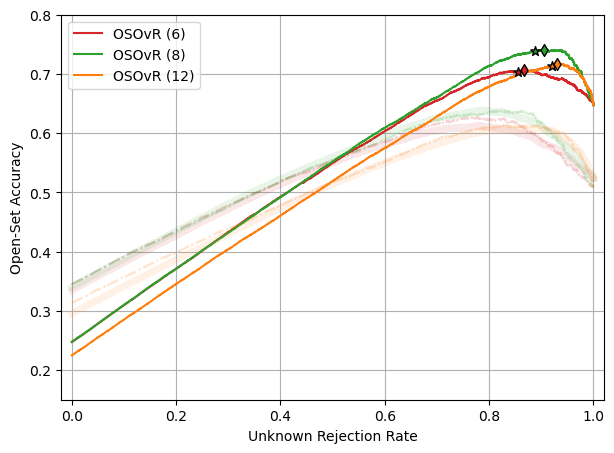

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.7020	0.2785±0.1824	0.5775	0.6123	0.6279	0.7073	0.6210	0.7038
0.7007	0.3198±0.1710	0.6011	0.6383	0.6384	0.7409	0.6361	0.7384
0.6373	0.6235±0.1546	0.5200	0.6084	0.6134	0.7167	0.6115	0.7134


In [17]:
evals.plot_OSAC(data_info, [CMAP_t10[3],CMAP_t10[2],CMAP_t10[1]], figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

#### Loss weighting - neg 0 - C, F, M 
- Best C (OvR/OSOvR) : global / global
- Best F (OvR/OSOvR) : 1 / 1
- Best M (OvR/OSOvR) : 0.4 / 0.4

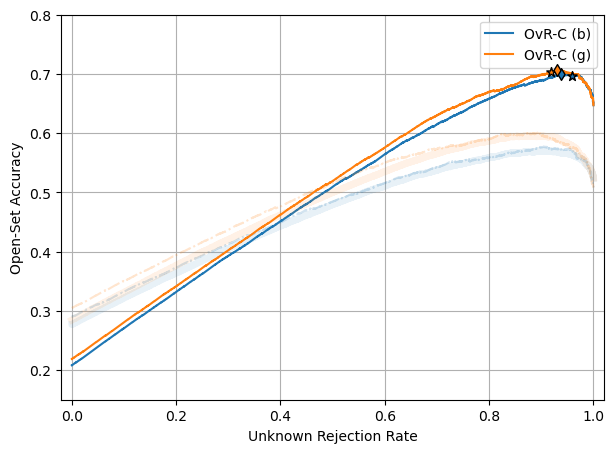

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.5900	0.3840±0.2083	0.4822	0.5706	0.5770	0.6993	0.5728	0.6962
0.6200	0.3543±0.1734	0.5111	0.5954	0.6007	0.7066	0.5984	0.7028


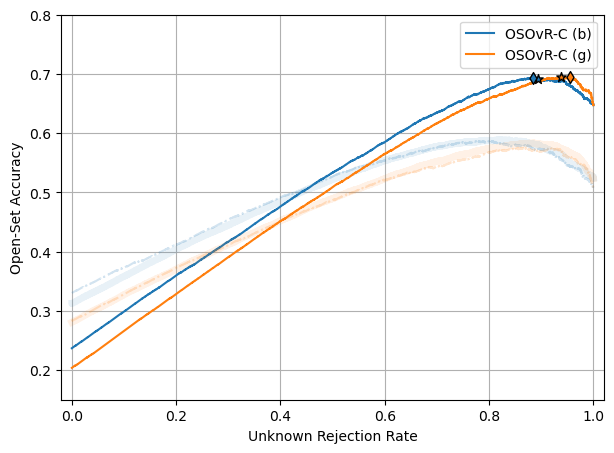

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.6713	0.3030±0.1727	0.5362	0.5889	0.5872	0.6929	0.5813	0.6913
0.5773	0.3980±0.1592	0.4772	0.5836	0.5757	0.6948	0.5718	0.6946


In [19]:
PROTOCOL = 2

data_info = ovr_data_info_2_T[PROTOCOL-1]['C']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_2_T[PROTOCOL-1]['C']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

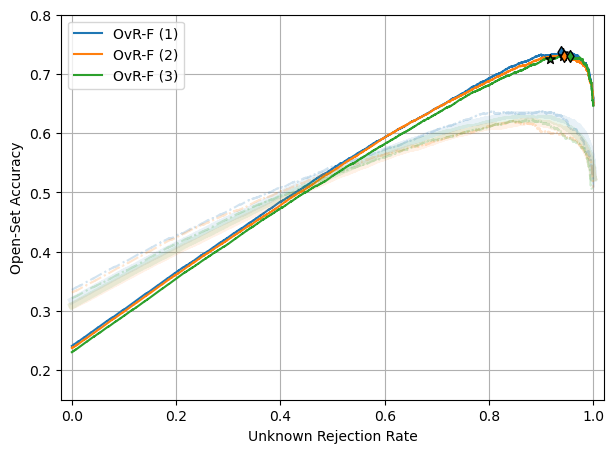

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.6820	0.3714±0.1719	0.5732	0.6319	0.6377	0.7362	0.6374	0.7355
0.6727	0.3857±0.1611	0.5631	0.6204	0.6213	0.7311	0.6161	0.7304
0.6527	0.4112±0.1687	0.5445	0.6256	0.6226	0.7308	0.6187	0.7247


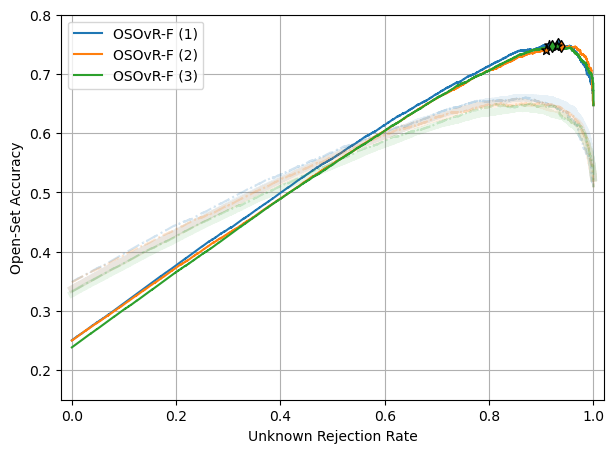

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.7093	0.3057±0.1552	0.6182	0.6604	0.6603	0.7508	0.6597	0.7494
0.7080	0.3236±0.1683	0.6010	0.6531	0.6511	0.7480	0.6485	0.7407
0.6753	0.3223±0.2080	0.5934	0.6425	0.6498	0.7473	0.6492	0.7464


In [20]:
PROTOCOL = 2

data_info = ovr_data_info_2_T[PROTOCOL-1]['F']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_2_T[PROTOCOL-1]['F']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

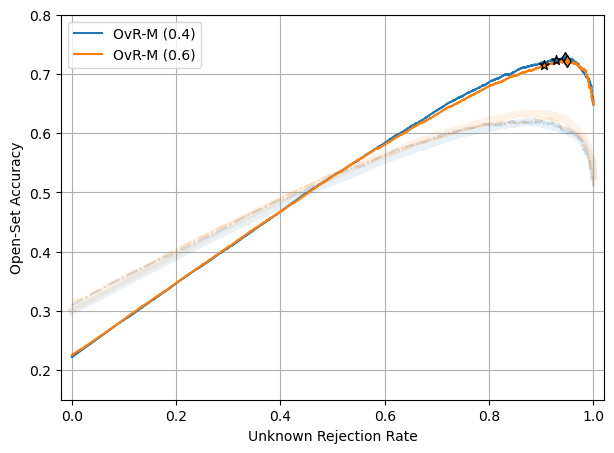

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.6300	0.3891±0.1769	0.5365	0.6194	0.6200	0.7273	0.6180	0.7242
0.6387	0.3889±0.1704	0.5313	0.6332	0.6256	0.7224	0.6184	0.7144


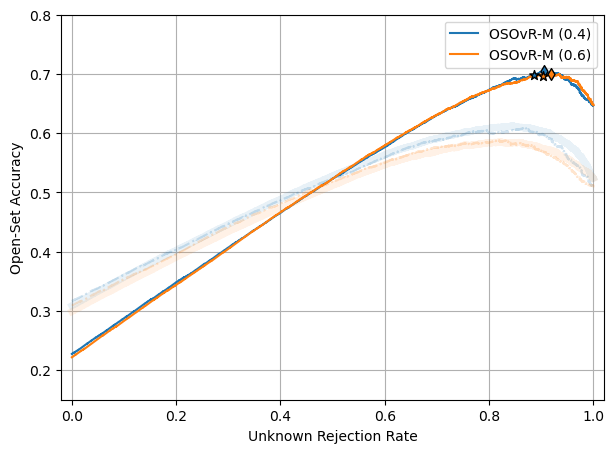

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.6440	0.3919±0.1558	0.5177	0.6123	0.6092	0.7047	0.6049	0.6988
0.6280	0.3920±0.1637	0.5157	0.5851	0.5879	0.6998	0.5833	0.6972


In [21]:
PROTOCOL = 2

data_info = ovr_data_info_2_T[PROTOCOL-1]['M']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_2_T[PROTOCOL-1]['M']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

#### Loss weighting - neg All - C, F, M 
- Best C (OvR/OSOvR) : global / batch
- Best F (OvR/OSOvR) : 3 / 1
- Best M (OvR/OSOvR) : 0.6 / 0.6

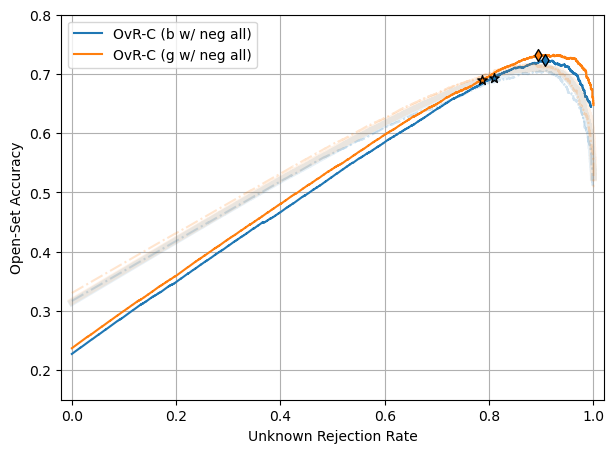

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.6440	0.3658±0.1561	0.5388	0.7109	0.7056	0.7231	0.7026	0.6939
0.6713	0.3280±0.1297	0.5717	0.7105	0.7170	0.7325	0.7118	0.6901


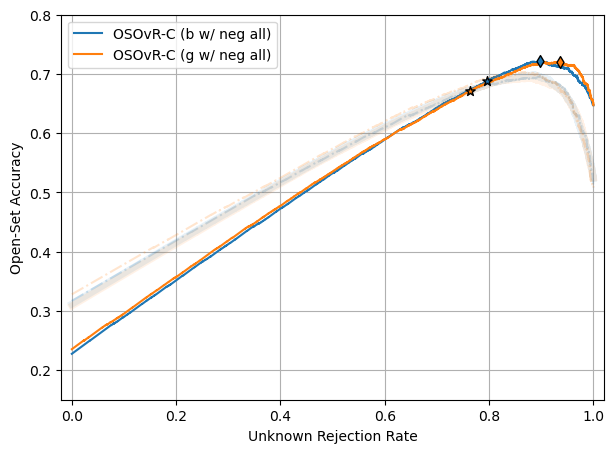

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.6447	0.3633±0.1532	0.5450	0.6983	0.6961	0.7214	0.6928	0.6880
0.6667	0.3473±0.1396	0.5535	0.6929	0.7033	0.7207	0.7007	0.6715


In [22]:
PROTOCOL = 2

data_info = ovr_data_info_3_T[PROTOCOL-1]['C']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_3_T[PROTOCOL-1]['C']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

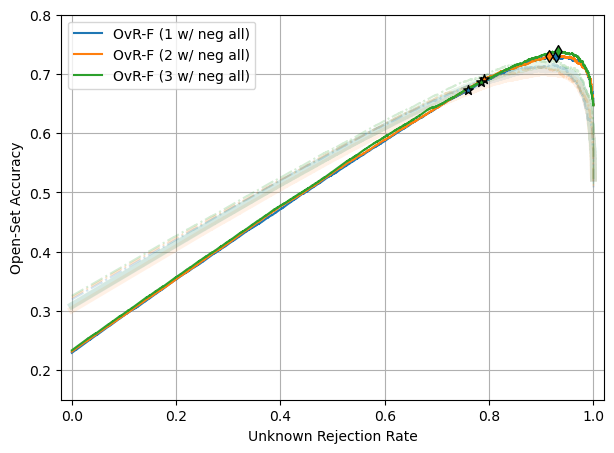

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.6493	0.4885±0.1440	0.5514	0.7093	0.7167	0.7299	0.7128	0.6722
0.6553	0.5060±0.1437	0.5557	0.7034	0.7125	0.7304	0.7118	0.6920
0.6613	0.5141±0.1652	0.5642	0.7153	0.7256	0.7395	0.7207	0.6864


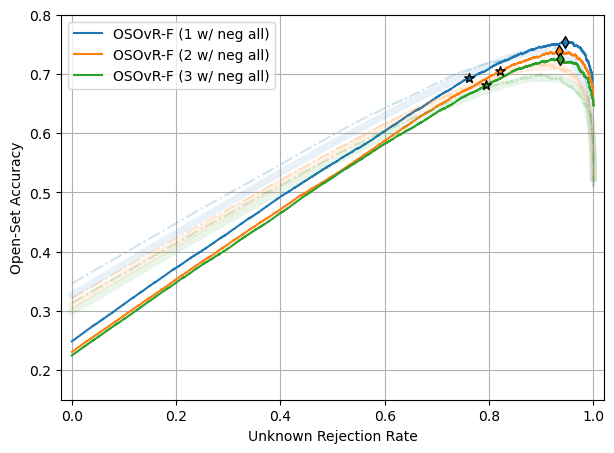

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.7040	0.4711±0.1599	0.6057	0.7387	0.7479	0.7546	0.7472	0.6932
0.6533	0.5074±0.1369	0.5553	0.7137	0.7177	0.7381	0.7118	0.7045
0.6367	0.5291±0.1589	0.5338	0.6941	0.6993	0.7259	0.6961	0.6809


In [23]:
PROTOCOL = 2

data_info = ovr_data_info_3_T[PROTOCOL-1]['F']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_3_T[PROTOCOL-1]['F']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

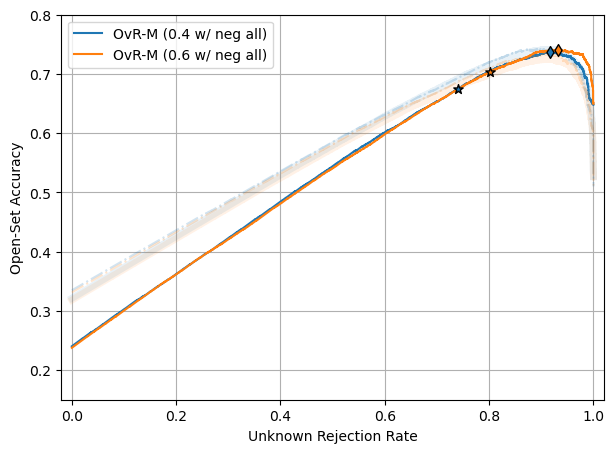

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.6807	0.4179±0.1563	0.5803	0.7414	0.7430	0.7372	0.7393	0.6751
0.6733	0.4554±0.1480	0.5798	0.7254	0.7341	0.7407	0.7315	0.7040


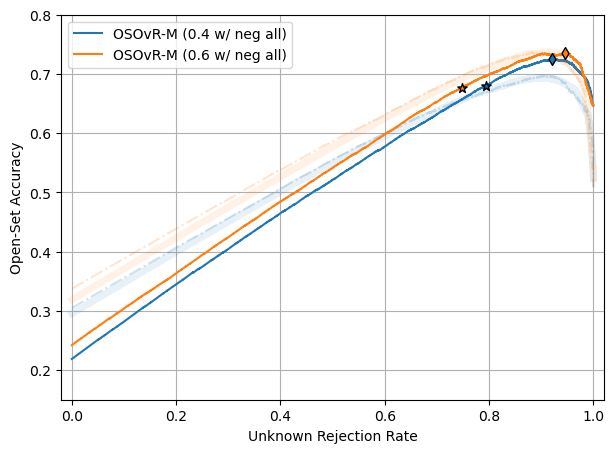

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.6200	0.5248±0.1429	0.5270	0.6940	0.6970	0.7247	0.6954	0.6795
0.6860	0.4390±0.1597	0.5784	0.7370	0.7361	0.7351	0.7318	0.6767


In [24]:
PROTOCOL = 2

data_info = ovr_data_info_3_T[PROTOCOL-1]['M']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

data_info = osovr_data_info_3_T[PROTOCOL-1]['M']
evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.15,0.8)))
results = evals.print_metrics(data_info)

### Result 4-1. Multiclass classifier vs. a set of One-vs-Rest classifiers

RQ1. Can a set of one-vs-rest classifiers effectively replace a single multiclass classifier in neural networks for image classification tasks?

SM vs. OvR vs. OSOvR.
- Accuracy
- Confusion Matrix with '-1'
- Score distribution
    - Target = P_c
    - Non-Target = max{t is not c}P_t
    - Negative = max{t}P_t
    - Unknown = max{t}P_t
- |FPR-FNR|
- OSCR Curve
- OSA Curve


#### Protocol 1

In [62]:
PROTOCOL = 1

In [63]:
data_info = sm_data_info_1[PROTOCOL-1] + ovr_data_info_1[PROTOCOL-1] + osovr_data_info_1[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'OpenSetOvR']


In [64]:
results = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.6612	0.3465±0.1528	0.6232	0.6152	0.6236	0.7623	0.6225	0.7618
0.7022	0.3615±0.1573	0.6544	0.6513	0.6613	0.7916	0.6581	0.7912
0.7043	0.3569±0.1614	0.6562	0.6419	0.6537	0.7784	0.6521	0.7777


In [65]:
# Skip confusion matrix

# evals.plot_confusion_mat(data_info, colors=plt.cm.binary,
#                          include_unknown=True,
#                          set_diag_mask=False, set_cmap_range=None,
#                          show_numbers=False, diag_sort=False)

[0.22362069 0.02948276 0.02       0.01896552] [0.52758621 0.03034483 0.02758621 0.01672414]
[0.22724138 0.02724138 0.01982759 0.01448276] [0.57396552 0.06034483 0.04293103 0.02517241]
[0.18448276 0.03327586 0.02103448 0.01741379] [0.49603448 0.07793103 0.05534483 0.03586207]


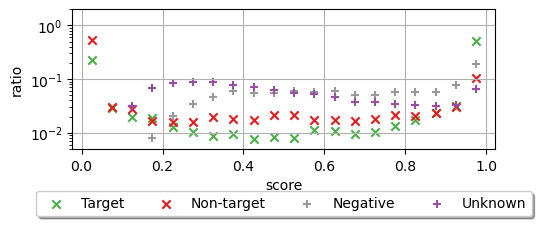

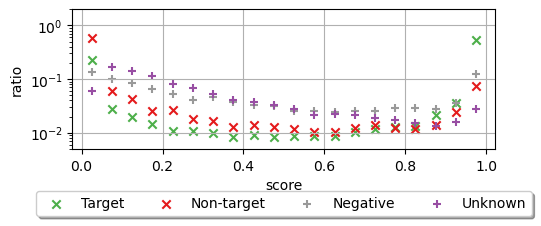

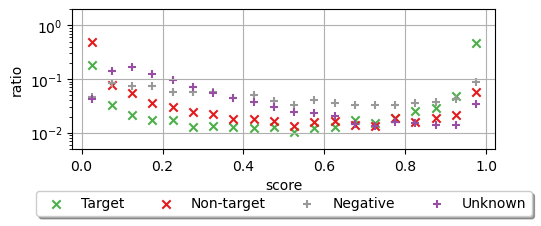

In [66]:
start, stop, step = 0, 1, 0.05
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
evals.plot_score_dist(data_info, bins, colors=colors, figsize=(5.5,2.5), ylim=(5e-3,2))

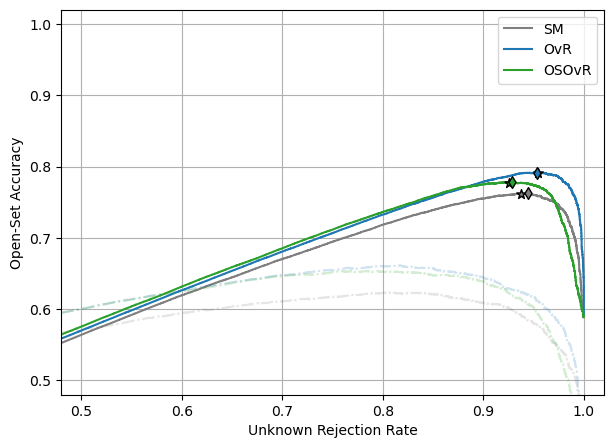

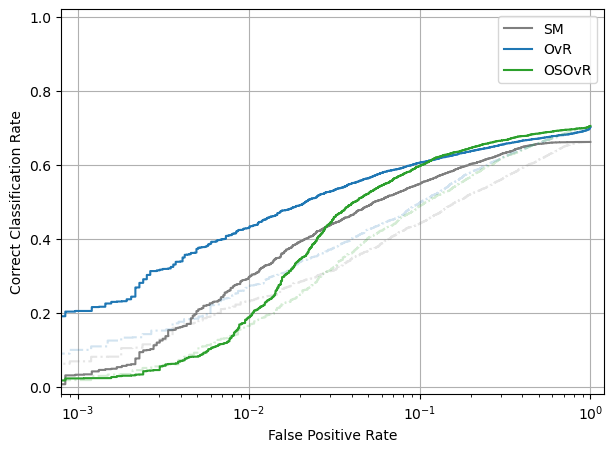

In [69]:
evals.plot_OSAC(data_info, [CMAP_t10[7],CMAP_t10[0],CMAP_t10[2]], figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
evals.plot_OSCR(data_info, [CMAP_t10[7],CMAP_t10[0],CMAP_t10[2]], figsize=(7,5), show_val=False, lim=((0.8e-3,1.2),(-.02,1.02)),)

#### Protocol 2

In [70]:
PROTOCOL = 2

In [71]:
data_info = sm_data_info_1[PROTOCOL-1] + ovr_data_info_1[PROTOCOL-1] + osovr_data_info_1[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OpenSetOvR']


In [72]:
results = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.6533	0.3411±0.1662	0.5487	0.6228	0.6223	0.7273	0.6144	0.7261
0.6867	0.3687±0.1675	0.5690	0.6307	0.6364	0.7259	0.6331	0.7235
0.7007	0.3198±0.1710	0.6011	0.6383	0.6384	0.7409	0.6361	0.7384


<Figure size 500x500 with 0 Axes>

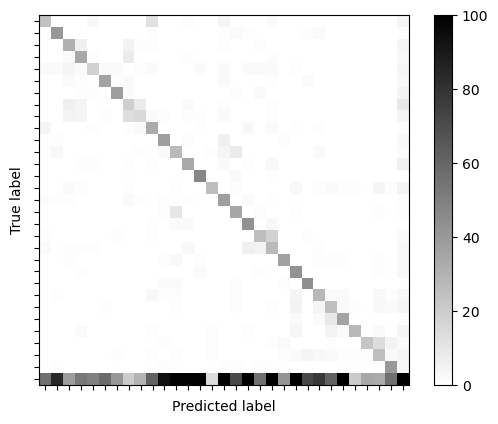

<Figure size 500x500 with 0 Axes>

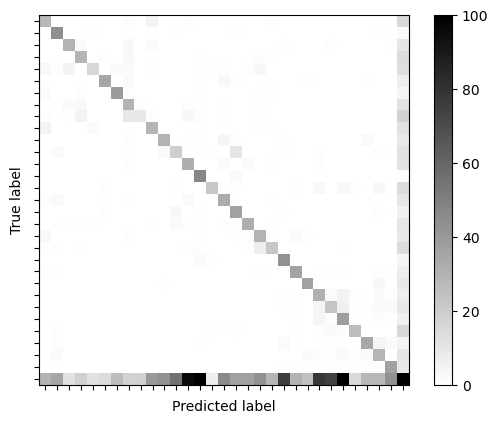

<Figure size 500x500 with 0 Axes>

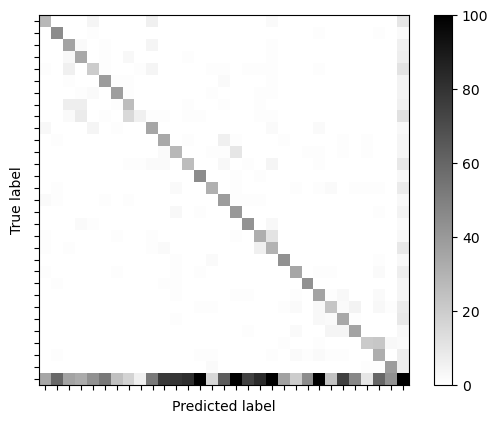

In [73]:
evals.plot_confusion_mat(data_info, colors=plt.cm.binary,
                         include_unknown=True,
                         set_diag_mask=False, set_cmap_range=(0,100),
                         show_numbers=False, diag_sort=False)

[0.20733333 0.03533333 0.02533333 0.01866667] [0.50866667 0.03733333 0.026      0.01933333]
[0.19133333 0.04333333 0.02466667 0.028     ] [0.446      0.084      0.05466667 0.04733333]
[0.19733333 0.02666667 0.016      0.01533333] [0.55066667 0.044      0.02733333 0.02733333]


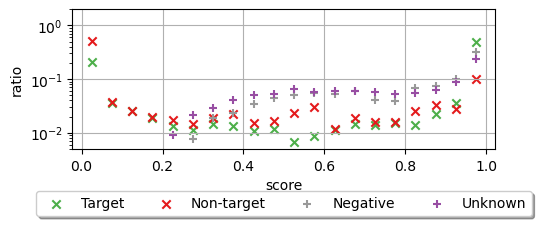

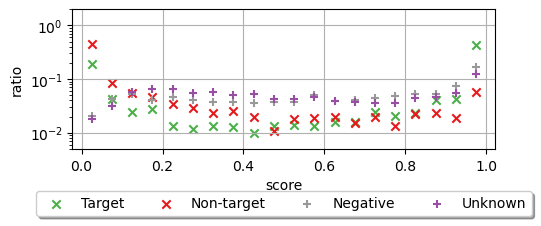

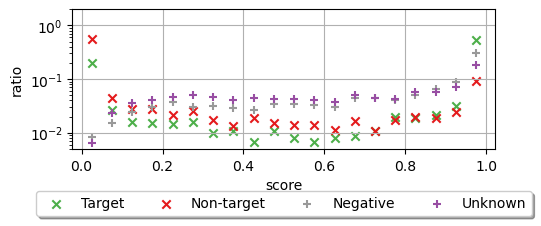

In [74]:
start, stop, step = 0, 1, 0.05
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
evals.plot_score_dist(data_info, bins, colors=colors, figsize=(5.5,2.5), ylim=(5e-3,2))

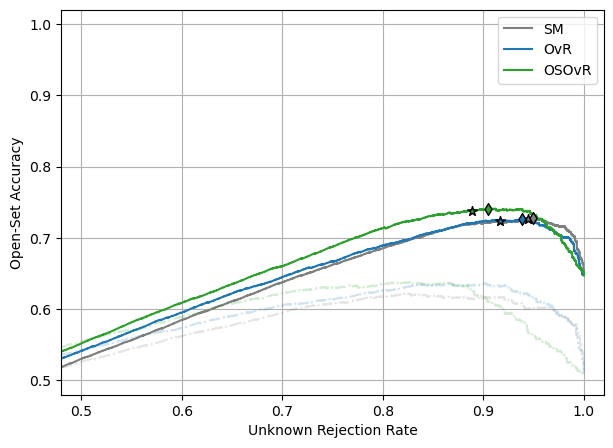

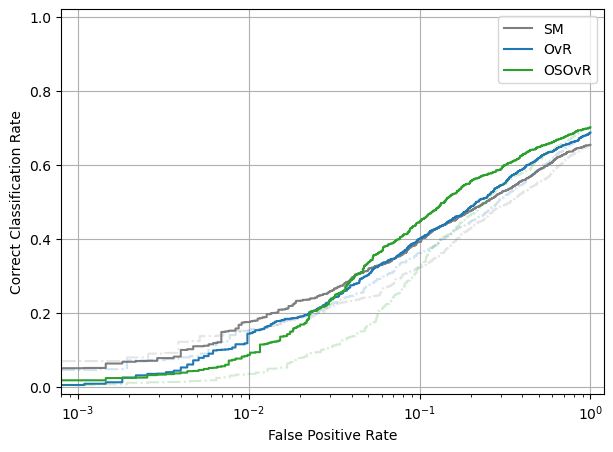

In [75]:
evals.plot_OSAC(data_info, [CMAP_t10[7],CMAP_t10[0],CMAP_t10[2]], figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
evals.plot_OSCR(data_info, [CMAP_t10[7],CMAP_t10[0],CMAP_t10[2]], figsize=(7,5), show_val=False, lim=((0.8e-3,1.2),(-.02,1.02)),)

#### Protocol 3

In [76]:
PROTOCOL = 3

In [77]:
data_info = sm_data_info_1[PROTOCOL-1] + ovr_data_info_1[PROTOCOL-1] + osovr_data_info_1[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'SoftMax']
['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_3', '_RQ1', 'ResNet_50_neg_0', 'OpenSetOvR']


In [78]:
results = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.7754	0.2275±0.1347	0.6822	0.6460	0.6531	0.7266	0.6515	0.7227
0.7645	0.2877±0.1573	0.6778	0.6589	0.6623	0.7314	0.6614	0.7260
0.7893	0.2491±0.1440	0.6816	0.6567	0.6592	0.7217	0.6585	0.7178


In [79]:
# Skip confusion matrix

# evals.plot_confusion_mat(data_info, colors=plt.cm.binary,
#                          include_unknown=True,
#                          set_diag_mask=False, set_cmap_range=None,
#                          show_numbers=False, diag_sort=False)

[0.16503311 0.01364238 0.00953642 0.00913907] [0.69417219 0.0218543  0.01668874 0.01059603]
[0.20715232 0.01827815 0.01086093 0.00635762] [0.71827815 0.04317881 0.02437086 0.01880795]
[0.1589404  0.01788079 0.01165563 0.00834437] [0.70264901 0.04410596 0.02596026 0.0189404 ]


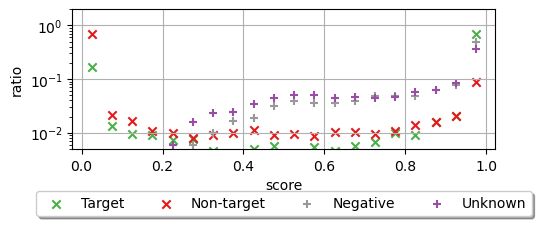

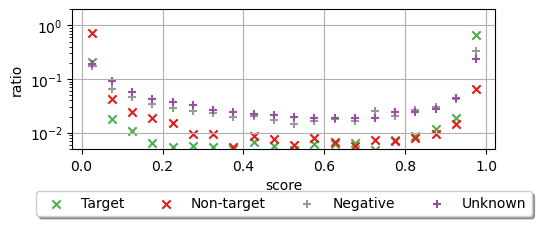

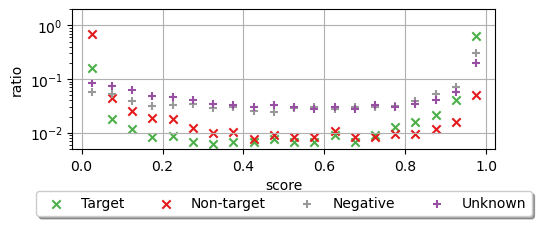

In [80]:
start, stop, step = 0, 1, 0.05
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
evals.plot_score_dist(data_info, bins, colors=colors, figsize=(5.5,2.5), ylim=(5e-3,2))

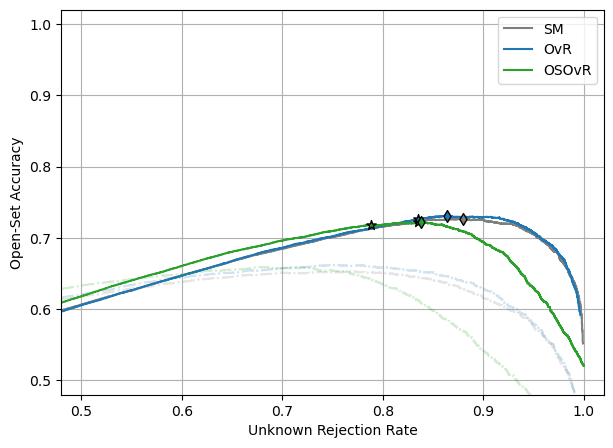

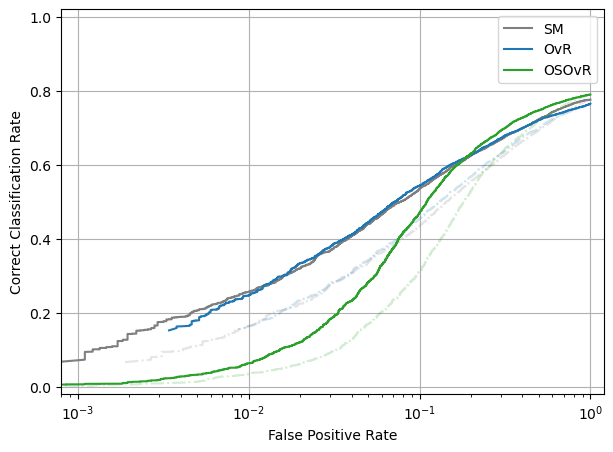

In [81]:
evals.plot_OSAC(data_info, [CMAP_t10[7],CMAP_t10[0],CMAP_t10[2]], figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
evals.plot_OSCR(data_info, [CMAP_t10[7],CMAP_t10[0],CMAP_t10[2]], figsize=(7,5), show_val=False, lim=((0.8e-3,1.2),(-.02,1.02)),)

### Result 4-2. Loss weighting approaches for data imbalance issue
RQ2. Which loss weighting approach for a set of one-vs-rest classifiers reduces performance imbalance, and how does it impact overall classification performance?

OvR vs. -C vs. -F vs. -M

OSOvR vs. -C vs. -F vs. -M

- Accuracy
- Confusion Matrix with '-1'
- Score distribution
    - Target = P_c
    - Non-Target = max{t is not c}P_t
    - Negative = max{t}P_t
    - Unknown = max{t}P_t
- |FPR-FNR|
- OSCR Curve
- OSA Curve

#### Protocol 1

In [16]:
PROTOCOL = 1

data_info = ovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_M_neg_0_04', 'OvR']


In [83]:
results = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.7022	0.3615±0.1573	0.6544	0.6513	0.6613	0.7916	0.6581	0.7912
0.0000	0.3615±0.1573	0.0000	0.0000	0.0000	0.0000	0.0000	0.0000
0.0000	0.3615±0.1573	0.0000	0.0000	0.0000	0.0000	0.0000	0.0000
0.0000	0.3615±0.1573	0.0000	0.0000	0.0000	0.0000	0.0000	0.0000


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.7022	0.9833	0.6544	0.6513	0.6581	0.7912	0.6613	0.7916
0.7028	0.9765	0.6634	0.7624	0.7751	0.5597	0.7758	0.7947


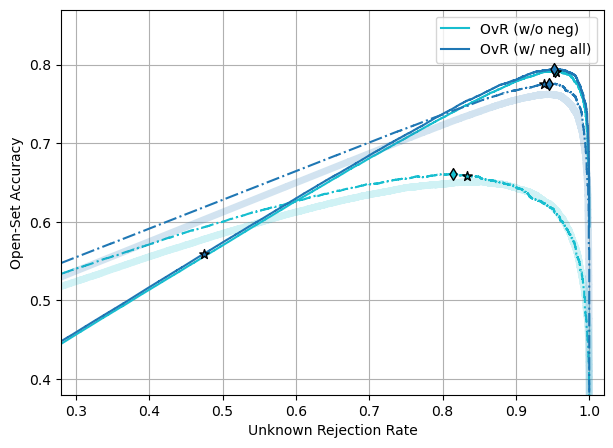

In [48]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [CMAP[9],CMAP[0],], 
                figsize=(7,5), lim=((0.28, 1.02),(0.38,0.87)),
                show_val=True)

In [49]:
PROTOCOL = 1

data_info = osovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50', 'OpenSetOvR']
['LargeScale_1', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.7043	0.9813	0.6562	0.6419	0.6521	0.7777	0.6537	0.7784
0.7179	0.9824	0.6819	0.7677	0.7892	0.5679	0.7894	0.8036


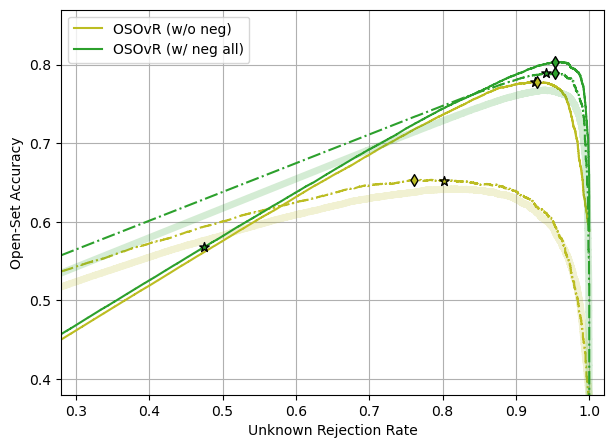

In [50]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [CMAP[8],CMAP[2],], 
                figsize=(7,5), lim=((0.28, 1.02),(0.38,0.87)),
                show_val=True)

In [62]:
PROTOCOL = 1

data_info = eos_data_info_1[PROTOCOL-1] + ovr_data_info_2[PROTOCOL-1][-1:] + osovr_data_info_2[PROTOCOL-1][-1:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_1', '_RQ2', 'ResNet_50_neg_All', 'OvR']
['LargeScale_1', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6805	0.9789	0.6706	0.7669	0.7830	0.7671	0.7835	0.8184
0.7028	0.9765	0.6634	0.7624	0.7751	0.5597	0.7758	0.7947
0.7179	0.9824	0.6819	0.7677	0.7892	0.5679	0.7894	0.8036


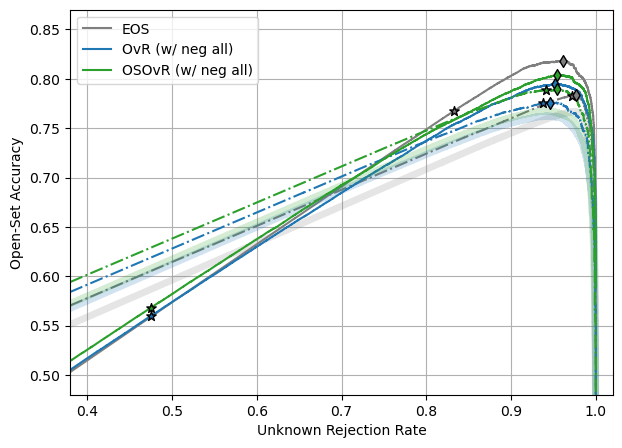

In [63]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [CMAP[7],CMAP[0],CMAP[2]], 
                figsize=(7,5), lim=((0.38, 1.02),(0.48,0.87)),
                show_val=True)

#### Protocol 2

In [79]:
PROTOCOL = 2

##### OvR

In [83]:
data_info = ovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_M_neg_0_04', 'OvR']


In [84]:
results = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.6867	0.3687±0.1675	0.5690	0.6307	0.6364	0.7259	0.6331	0.7235
0.6200	0.3543±0.1734	0.5111	0.5954	0.6007	0.7066	0.5984	0.7028
0.6820	0.3714±0.1719	0.5732	0.6319	0.6377	0.7362	0.6374	0.7355
0.6300	0.3891±0.1769	0.5365	0.6194	0.6200	0.7273	0.6180	0.7242


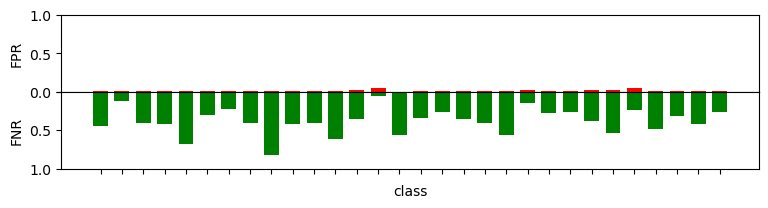

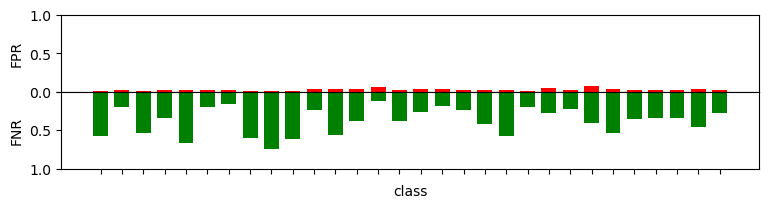

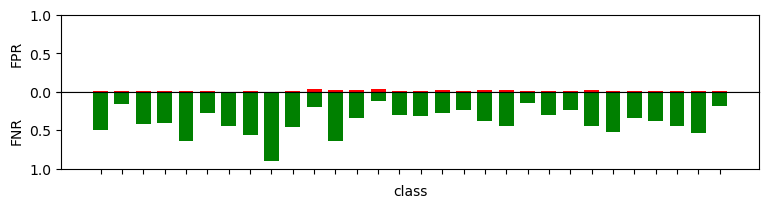

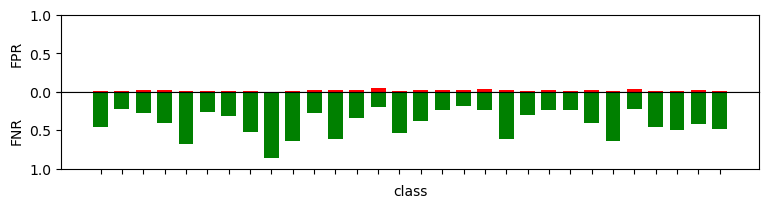

In [85]:
evals.plot_fpr_fnr_class(data_info, ylim=(0.0,1))

<Figure size 500x500 with 0 Axes>

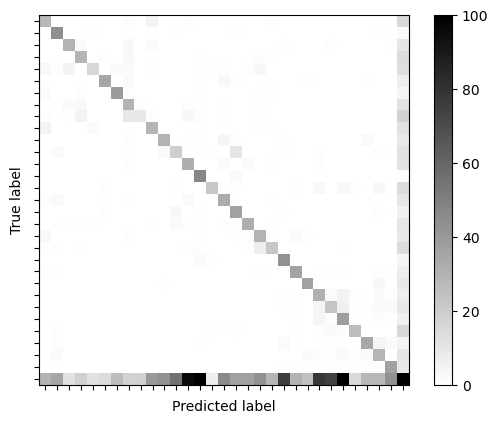

<Figure size 500x500 with 0 Axes>

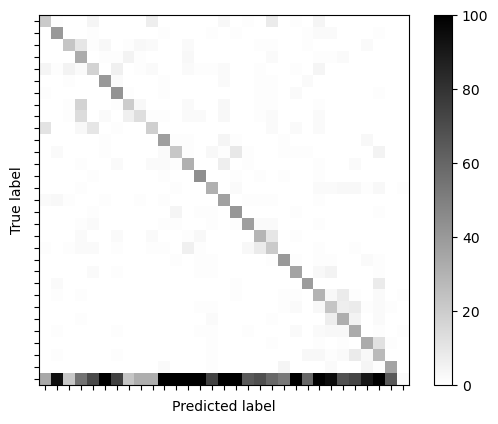

<Figure size 500x500 with 0 Axes>

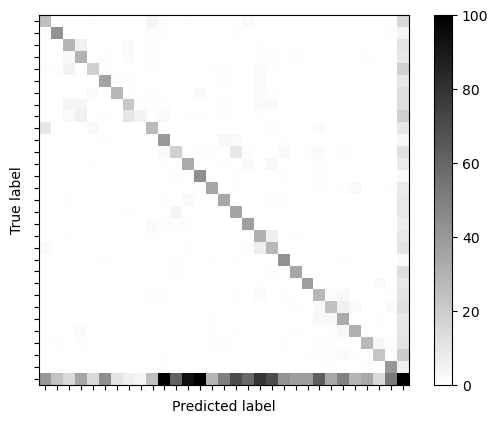

<Figure size 500x500 with 0 Axes>

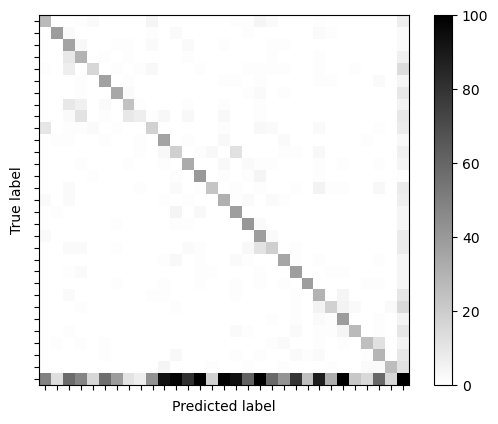

In [40]:
evals.plot_confusion_mat(data_info, colors=plt.cm.binary,
                         include_unknown=True,
                         set_diag_mask=False, set_cmap_range=(0,100),
                         show_numbers=False, diag_sort=False)

[0.19133333 0.04333333 0.02466667 0.028     ] [0.446      0.084      0.05466667 0.04733333]
[0.03333333 0.01333333 0.00866667 0.01      ] [0.04       0.01466667 0.01133333 0.01866667]
[0.15866667 0.044      0.02666667 0.02466667] [0.366      0.07733333 0.068      0.05733333]
[0.27066667 0.028      0.01666667 0.016     ] [0.44533333 0.05466667 0.04133333 0.03      ]


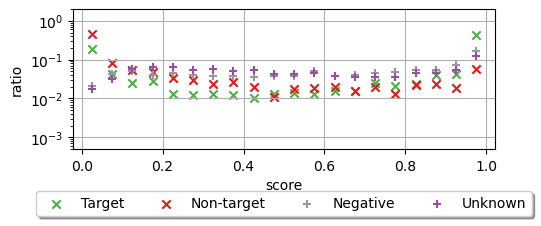

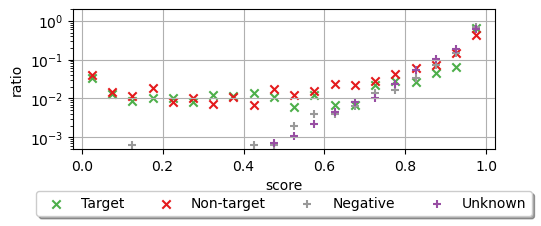

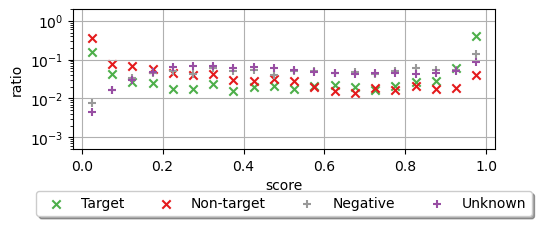

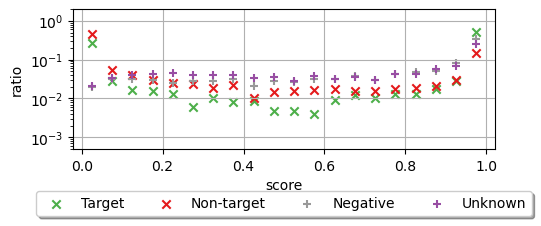

In [43]:
start, stop, step = 0, 1, 0.05
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
evals.plot_score_dist(data_info, bins, colors=colors, figsize=(5.5,2.5), ylim=(5e-4,2))

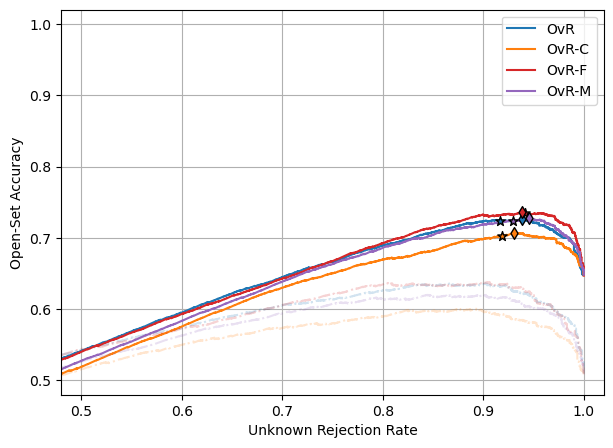

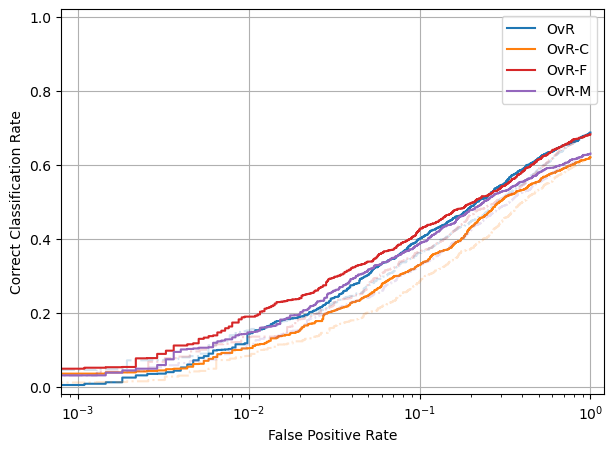

In [23]:
colors = [CMAP_t10[0],CMAP_t10[1],CMAP_t10[3], CMAP_t10[4]]
evals.plot_OSAC(data_info, colors, figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
evals.plot_OSCR(data_info, colors, figsize=(7,5), show_val=False, lim=((0.8e-3,1.2),(-.02,1.02)),)

##### OSOvR

In [86]:
data_info = osovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OpenSetOvR']
['LargeScale_2', '_RQ2', 'ResNet_50_C_neg_0_g', 'OpenSetOvR']
['LargeScale_2', '_RQ2', 'ResNet_50_F_neg_0_1', 'OpenSetOvR']
['LargeScale_2', '_RQ2', 'ResNet_50_M_neg_0_04', 'OpenSetOvR']


In [87]:
results = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.7007	0.3198±0.1710	0.6011	0.6383	0.6384	0.7409	0.6361	0.7384
0.5773	0.3980±0.1592	0.4772	0.5836	0.5757	0.6948	0.5718	0.6946
0.7093	0.3057±0.1552	0.6182	0.6604	0.6603	0.7508	0.6597	0.7494
0.6440	0.3919±0.1558	0.5177	0.6123	0.6092	0.7047	0.6049	0.6988


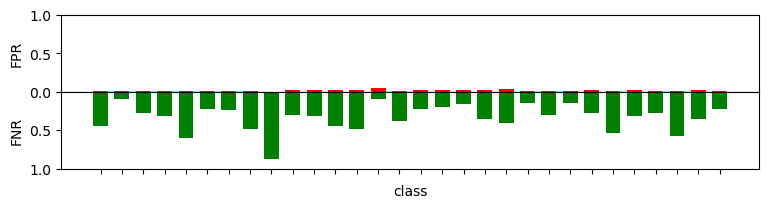

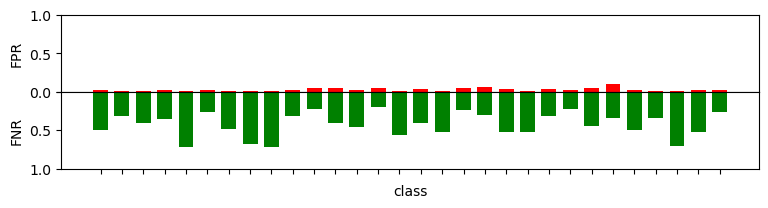

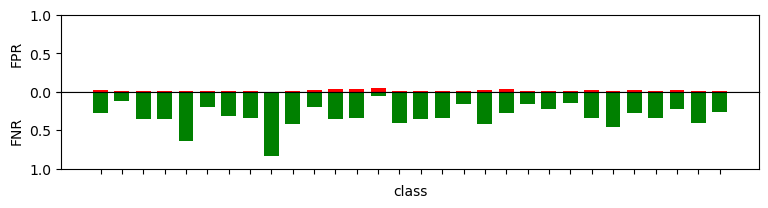

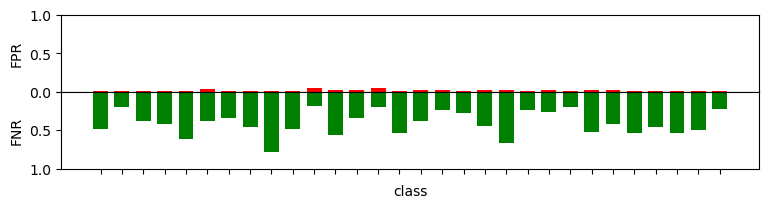

In [88]:
evals.plot_fpr_fnr_class(data_info, ylim=(0.0,1))

<Figure size 500x500 with 0 Axes>

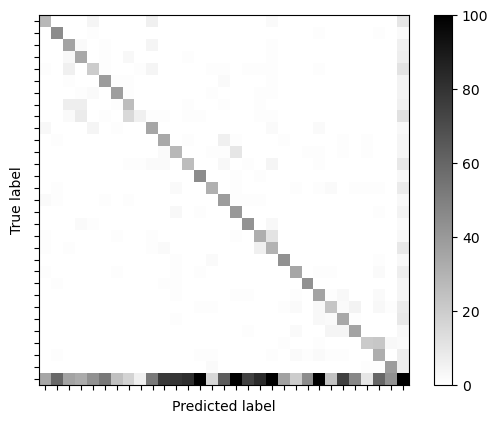

<Figure size 500x500 with 0 Axes>

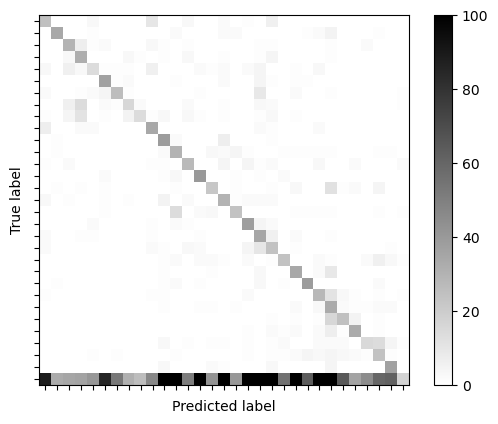

<Figure size 500x500 with 0 Axes>

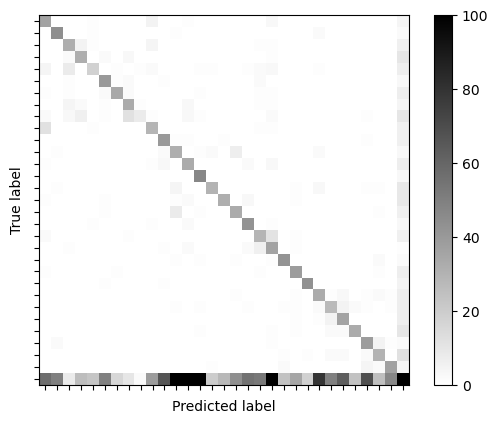

<Figure size 500x500 with 0 Axes>

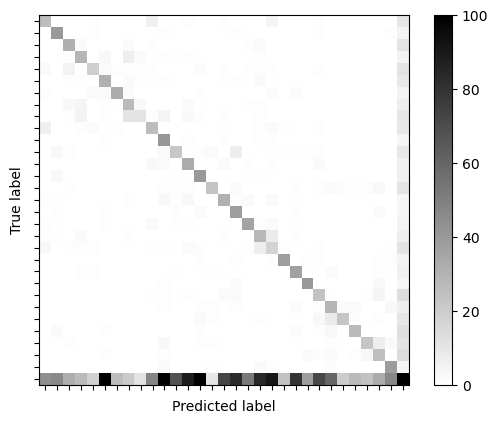

In [46]:
evals.plot_confusion_mat(data_info, colors=plt.cm.binary,
                         include_unknown=True,
                         set_diag_mask=False, set_cmap_range=(0,100),
                         show_numbers=False, diag_sort=False)

[0.19733333 0.02666667 0.016      0.01533333] [0.55066667 0.044      0.02733333 0.02733333]
[0.02266667 0.01533333 0.01333333 0.012     ] [0.03866667 0.01266667 0.00933333 0.00733333]
[0.10733333 0.04066667 0.02333333 0.03066667] [0.39066667 0.07866667 0.04333333 0.04533333]
[0.20133333 0.03466667 0.03266667 0.02133333] [0.386      0.07133333 0.05       0.04      ]


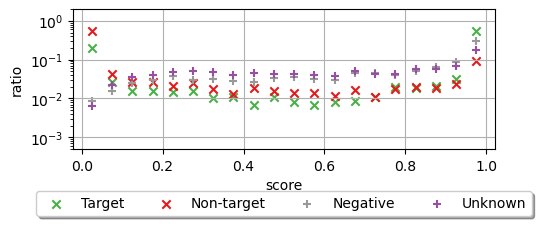

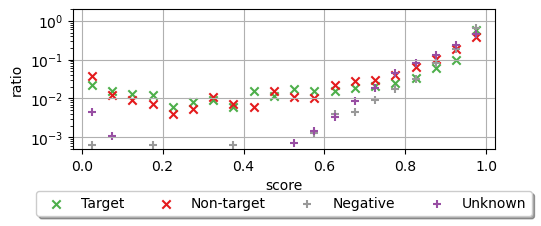

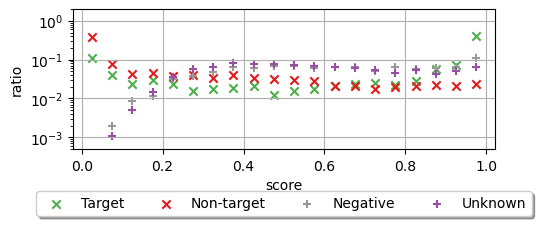

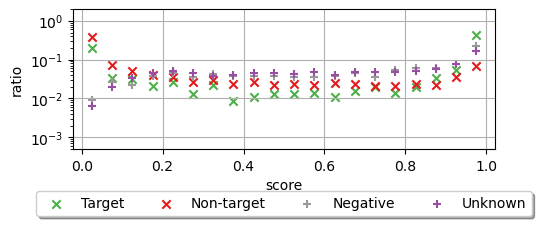

In [47]:
start, stop, step = 0, 1, 0.05
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
evals.plot_score_dist(data_info, bins, colors=colors, figsize=(5.5,2.5), ylim=(5e-4,2))

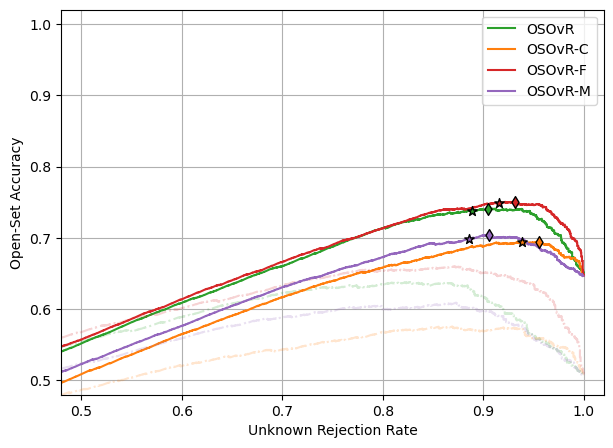

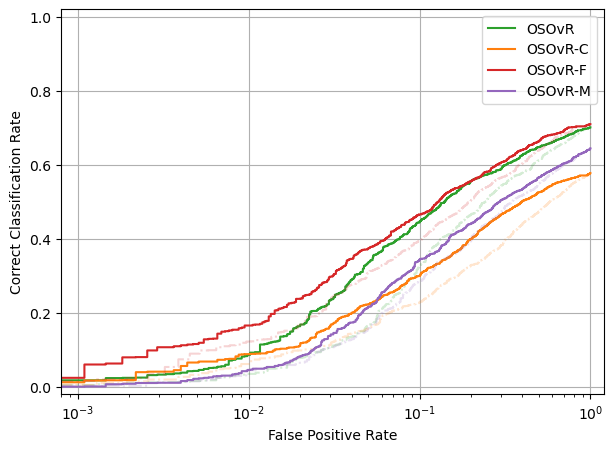

In [34]:
colors = [CMAP_t10[2],CMAP_t10[1],CMAP_t10[3], CMAP_t10[4]]
evals.plot_OSAC(data_info, colors, figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
evals.plot_OSCR(data_info, colors, figsize=(7,5), show_val=False, lim=((0.8e-3,1.2),(-.02,1.02)),)

#### Protocol 3

In [54]:
PROTOCOL = 3

data_info = ovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.7645	0.9876	0.6778	0.6589	0.6614	0.7260	0.6623	0.7314
0.7607	0.9809	0.6746	0.7331	0.7313	0.6960	0.7335	0.7343


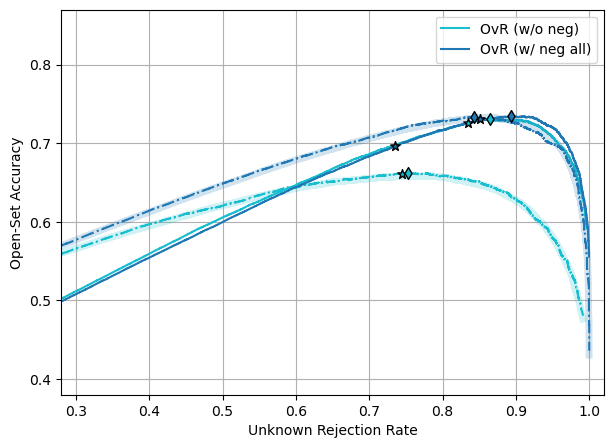

In [55]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [CMAP[9],CMAP[0],], 
                figsize=(7,5), lim=((0.28, 1.02),(0.38,0.87)),
                show_val=True)

In [56]:
PROTOCOL = 3

data_info = osovr_data_info_2[PROTOCOL-1]


for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50', 'OpenSetOvR']
['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn


0.7893	0.9915	0.6816	0.6567	0.6585	0.7178	0.6592	0.7217
0.7903	0.9889	0.6986	0.7648	0.7573	0.7021	0.7586	0.7437


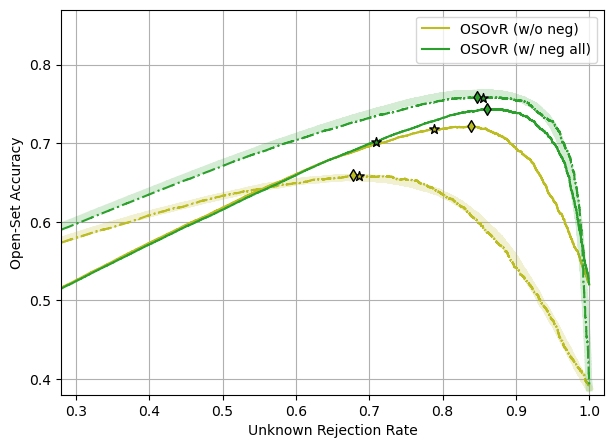

In [57]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [CMAP[8],CMAP[2],], 
                figsize=(7,5), lim=((0.28, 1.02),(0.38,0.87)),
                show_val=True)

In [66]:
PROTOCOL = 3

data_info = eos_data_info_1[PROTOCOL-1] + ovr_data_info_2[PROTOCOL-1][-1:] + osovr_data_info_2[PROTOCOL-1][-1:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.7521	0.9783	0.6813	0.7524	0.7492	0.7053	0.7502	0.7420
0.7607	0.9809	0.6746	0.7331	0.7313	0.6960	0.7335	0.7343
0.7903	0.9889	0.6986	0.7648	0.7573	0.7021	0.7586	0.7437


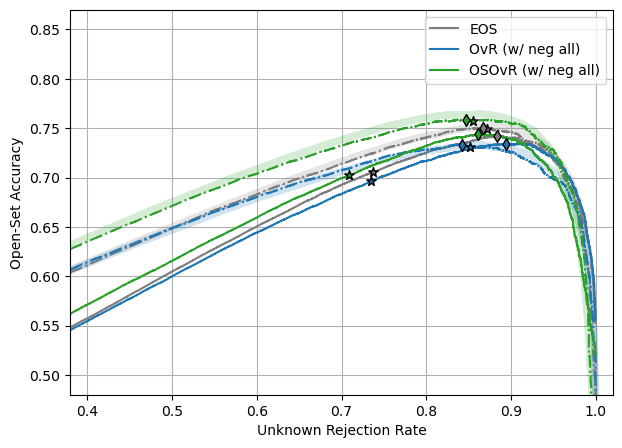

In [67]:
results = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, [CMAP[7],CMAP[0],CMAP[2]], 
                figsize=(7,5), lim=((0.38, 1.02),(0.48,0.87)),
                show_val=True)

### Result 4-3.Including negatives in training 

RQ3. Does including negative samples in training improve open-set classification performance, and can loss weighting approaches mitigate the negative effects of increased dataset imbalance?

.
- OvR vs. OvR (- 10k) vs. OvR (- 20k) vs. OvR (- 30k) vs. OvR (- All) 
- OvR-C vs. OvR-C (- 10k) vs. OvR-C (- 20k) vs. OvR-C (- 30k) vs. OvR-C (- All) 
- OvR-F vs. OvR-F (- 10k) vs. OvR-F (- 20k) vs. OvR-F (- 30k) vs. OvR-F (- All) 
- OvR-M vs. OvR-M (- 10k) vs. OvR-M (- 20k) vs. OvR-M (- 30k) vs. OvR-M (- All) 

.
- OSOvR vs. OSOvR (- 10k) vs. OSOvR (- 20k) vs. OSOvR (- 30k) vs. OSOvR (- All) 
- OSOvR-C vs. OSOvR-C (- 10k) vs. OSOvR-C (- 20k) vs. OSOvR-C (- 30k) vs. OSOvR-C (- All) 
- OSOvR-F vs. OSOvR-F (- 10k) vs. OSOvR-F (- 20k) vs. OSOvR-F (- 30k) vs. OSOvR-F (- All) 
- OSOvR-M vs. OSOvR-M (- 10k) vs. OSOvR-M (- 20k) vs. OSOvR-M (- 30k) vs. OSOvR-M (- All) 

.
- Accuracy
- Confusion Matrix with '-1'
- Score distribution
    - Target = P_c
    - Non-Target = max{t is not c}P_t
    - Negative = max{t}P_t
    - Unknown = max{t}P_t
- |FPR-FNR|
- OSCR Curve
- OSA Curve


#### Protocol 1

In [48]:
PROTOCOL = 1

##### OvR

In [51]:
data_info = ovr_data_info_3[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_C_neg_All_g', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']
['LargeScale_1', '_RQ3', 'ResNet_50_M_neg_All_06', 'OvR']


In [ ]:
results = evals.print_metrics(data_info)

In [ ]:
# evals.plot_fpr_fnr_class(data_info, ylim=(0.0,0.2))

In [ ]:
# evals.plot_confusion_mat(data_info, colors=plt.cm.binary,
#                          include_unknown=True,
#                          set_diag_mask=False, set_cmap_range=(0,100),
#                          show_numbers=False, diag_sort=False)

In [ ]:
start, stop, step = 0, 1, 0.05
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
evals.plot_score_dist(data_info, bins, colors=colors, figsize=(5.5,2.5), ylim=(5e-4,2))

In [ ]:
colors = [CMAP_t10[0],CMAP_t10[1],CMAP_t10[3], CMAP_t10[4]]
evals.plot_OSAC(data_info, colors, figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
evals.plot_OSCR(data_info, colors, figsize=(7,5), show_val=False, lim=((0.8e-3,1.2),(-.02,1.02)),)

In [ ]:
plot_results = [{'acc':results['acc'], 'iosa_unkn': [res['iosa_unkn'] for res in results['oosa']]}]
plot_results += [{'acc':results_c['acc'], 'iosa_unkn': [res['iosa_unkn'] for res in results_c['oosa']]}]
plot_results += [{'acc':results_f['acc'], 'iosa_unkn': [res['iosa_unkn'] for res in results_f['oosa']]}]
plot_results += [{'acc':results_m['acc'], 'iosa_unkn': [res['iosa_unkn'] for res in results_m['oosa']]}]
plot_colors = [CMAP_t10[0], CMAP_t10[1], CMAP_t10[3], CMAP_t10[4]]
plot_color_labels = ['OvR','OvR-C','OvR-F','OvR-M']

plot_items = ['iosa_unkn', 'acc']
plot_item_labels = ['Open-set Accuracy', 'Accuracy']
plot_item_ylims = [(0.775,1.005),(0.775,1.005)]
xticks = [0,0]

evals.plot_metrics(results=plot_results, colors=plot_colors, color_labels=plot_color_labels,
                   items=plot_items, item_labels=plot_item_labels, item_ylims=plot_item_ylims, 
                   xticks=xticks)

In [ ]:
x = np.array([0,1,2,3,4])

plt.figure(figsize=(7,5))

avg = [res['avg'] for res in results['fpr_fnr']]
std = [res['std'] for res in results['fpr_fnr']]
min = [res['min'] for res in results['fpr_fnr']]
max = [res['max'] for res in results['fpr_fnr']]
plt.errorbar(x, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[0], label='OvR', ls="None")
plt.plot(x, avg, color = CMAP_t10[0], ls="--", alpha=0.5, lw=1)

avg = [res['avg'] for res in results_c['fpr_fnr']]
std = [res['std'] for res in results_c['fpr_fnr']]
min_max = [[res['min'],[res['max']]] for res in results['fpr_fnr']]
plt.errorbar(x+0.1, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[1], label='OvR-C', ls="None")
plt.plot(x+0.1, avg, color = CMAP_t10[1], ls="--", alpha=0.5, lw=1)

avg = [res['avg'] for res in results_f['fpr_fnr']]
std = [res['std'] for res in results_f['fpr_fnr']]
min_max = [[res['min'],[res['max']]] for res in results['fpr_fnr']]
plt.errorbar(x+0.2, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[3], label='OvR-F', ls="None")
plt.plot(x+0.2, avg, color = CMAP_t10[3], ls="--", alpha=0.5, lw=1)

avg = [res['avg'] for res in results_m['fpr_fnr']]
std = [res['std'] for res in results_m['fpr_fnr']]
min_max = [[res['min'],[res['max']]] for res in results['fpr_fnr']]
plt.errorbar(x+0.3, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[4], label='OvR-M', ls="None")
plt.plot(x+0.3, avg, color = CMAP_t10[4], ls="--", alpha=0.5, lw=1)

plt.xticks(ticks=x, labels=[0,10000,20000,30000,42240])
plt.xlabel('# of negatives in training set')
plt.ylabel('Avg. of |FPR-FNR| by classes')
plt.ylim(-0.01,0.1)
plt.grid(axis='y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), shadow=True, ncol=4,)
plt.tight_layout()

##### OSOvR

In [53]:
data_info = osovr_data_info_3[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_1', '_RQ3', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_1', '_RQ3', 'ResNet_50_C_neg_All_b', 'OpenSetOvR']
['LargeScale_1', '_RQ3', 'ResNet_50_F_neg_All_1', 'OpenSetOvR']
['LargeScale_1', '_RQ3', 'ResNet_50_M_neg_All_06', 'OpenSetOvR']


In [ ]:
results = evals.print_metrics(data_info)

In [ ]:
# evals.plot_confusion_mat(data_info, colors=plt.cm.binary,
#                          include_unknown=True,
#                          set_diag_mask=False, set_cmap_range=(0,100),
#                          show_numbers=False, diag_sort=False)

In [ ]:
start, stop, step = 0, 1, 0.05
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
evals.plot_score_dist(data_info, bins, colors=colors, figsize=(5.5,2.5), ylim=(5e-4,2))

In [ ]:
colors = [CMAP_t10[2],CMAP_t10[1],CMAP_t10[3], CMAP_t10[4]]
evals.plot_OSAC(data_info, colors, figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
evals.plot_OSCR(data_info, colors, figsize=(7,5), show_val=False, lim=((0.8e-3,1.2),(-.02,1.02)),)

In [ ]:
plot_results = [{'acc':results['acc'], 'iosa_unkn': [res['iosa_unkn'] for res in results['oosa']]}]
plot_results += [{'acc':results_c['acc'], 'iosa_unkn': [res['iosa_unkn'] for res in results_c['oosa']]}]
plot_results += [{'acc':results_f['acc'], 'iosa_unkn': [res['iosa_unkn'] for res in results_f['oosa']]}]
plot_results += [{'acc':results_m['acc'], 'iosa_unkn': [res['iosa_unkn'] for res in results_m['oosa']]}]
plot_colors = [CMAP_t10[0], CMAP_t10[1], CMAP_t10[3], CMAP_t10[4]]
plot_color_labels = ['OvR','OvR-C','OvR-F','OvR-M']

plot_items = ['iosa_unkn', 'acc']
plot_item_labels = ['Open-set Accuracy', 'Accuracy']
plot_item_ylims = [(0.775,1.005),(0.775,1.005)]
xticks = [0,0]

evals.plot_metrics(results=plot_results, colors=plot_colors, color_labels=plot_color_labels,
                   items=plot_items, item_labels=plot_item_labels, item_ylims=plot_item_ylims, 
                   xticks=xticks)

In [ ]:
x = np.array([0,1,2,3,4])

plt.figure(figsize=(7,5))

avg = [res['avg'] for res in results['fpr_fnr']]
std = [res['std'] for res in results['fpr_fnr']]
min = [res['min'] for res in results['fpr_fnr']]
max = [res['max'] for res in results['fpr_fnr']]
plt.errorbar(x, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[0], label='OvR', ls="None")
plt.plot(x, avg, color = CMAP_t10[0], ls="--", alpha=0.5, lw=1)

avg = [res['avg'] for res in results_c['fpr_fnr']]
std = [res['std'] for res in results_c['fpr_fnr']]
min_max = [[res['min'],[res['max']]] for res in results['fpr_fnr']]
plt.errorbar(x+0.1, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[1], label='OvR-C', ls="None")
plt.plot(x+0.1, avg, color = CMAP_t10[1], ls="--", alpha=0.5, lw=1)

avg = [res['avg'] for res in results_f['fpr_fnr']]
std = [res['std'] for res in results_f['fpr_fnr']]
min_max = [[res['min'],[res['max']]] for res in results['fpr_fnr']]
plt.errorbar(x+0.2, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[3], label='OvR-F', ls="None")
plt.plot(x+0.2, avg, color = CMAP_t10[3], ls="--", alpha=0.5, lw=1)

avg = [res['avg'] for res in results_m['fpr_fnr']]
std = [res['std'] for res in results_m['fpr_fnr']]
min_max = [[res['min'],[res['max']]] for res in results['fpr_fnr']]
plt.errorbar(x+0.3, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[4], label='OvR-M', ls="None")
plt.plot(x+0.3, avg, color = CMAP_t10[4], ls="--", alpha=0.5, lw=1)

plt.xticks(ticks=x, labels=[0,10000,20000,30000,42240])
plt.xlabel('# of negatives in training set')
plt.ylabel('Avg. of |FPR-FNR| by classes')
plt.ylim(-0.01,0.1)
plt.grid(axis='y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), shadow=True, ncol=4,)
plt.tight_layout()

#### Protocol 2

In [16]:
PROTOCOL = 2

##### EOS

In [70]:
data_info = eos_data_info_3[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ3', 'ResNet_50_neg_All', 'EOS']


In [71]:
results = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.6567	0.4446±0.1606	0.5804	0.7484	0.7433	0.7527	0.7393	0.6781


<Figure size 500x500 with 0 Axes>

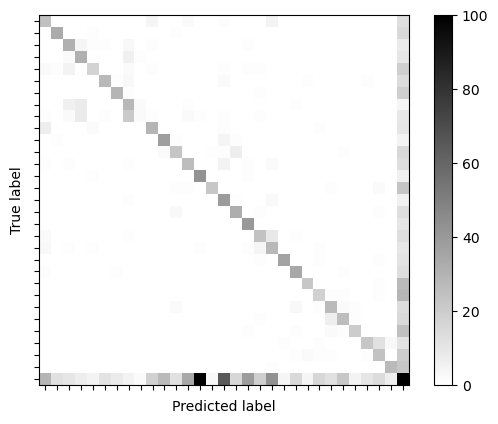

In [72]:
evals.plot_confusion_mat(data_info, colors=plt.cm.binary,
                         include_unknown=True,
                         set_diag_mask=False, set_cmap_range=(0,100),
                         show_numbers=False, diag_sort=False)

##### OvR

In [63]:
data_info = ovr_data_info_3[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ3', 'ResNet_50_neg_All', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_C_neg_All_g', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_F_neg_All_3', 'OvR']
['LargeScale_2', '_RQ3', 'ResNet_50_M_neg_All_06', 'OvR']


In [64]:
results_neg_All = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn
0.6600	0.4933±0.1643	0.5706	0.7244	0.7325	0.7478	0.7269	0.7024
0.6713	0.3280±0.1297	0.5717	0.7105	0.7170	0.7325	0.7118	0.6901
0.6613	0.5141±0.1652	0.5642	0.7153	0.7256	0.7395	0.7207	0.6864
0.6733	0.4554±0.1480	0.5798	0.7254	0.7341	0.7407	0.7315	0.7040


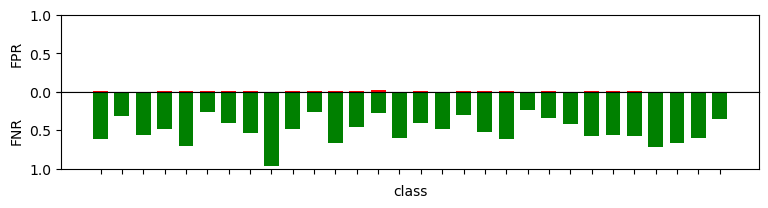

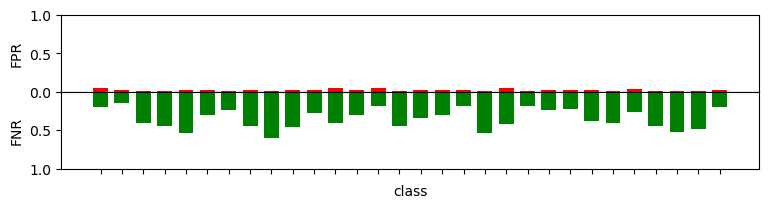

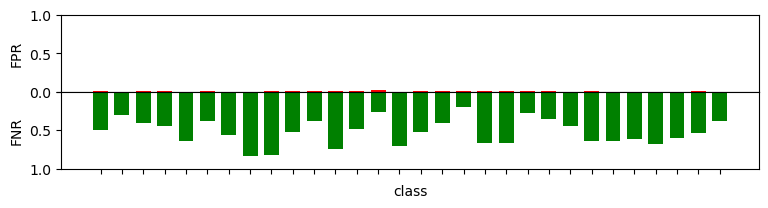

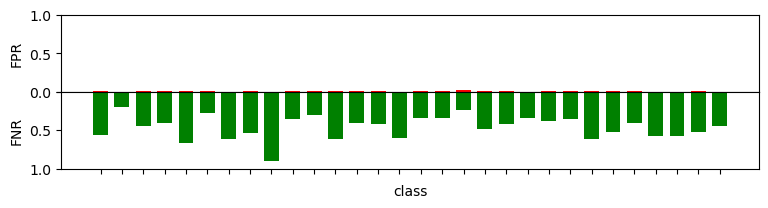

In [19]:
evals.plot_fpr_fnr_class(data_info, ylim=(0.0,1))

<Figure size 500x500 with 0 Axes>

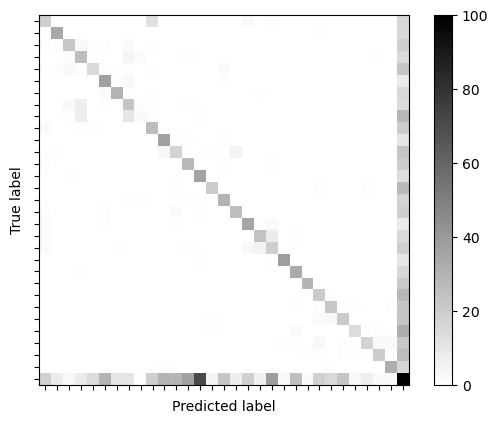

<Figure size 500x500 with 0 Axes>

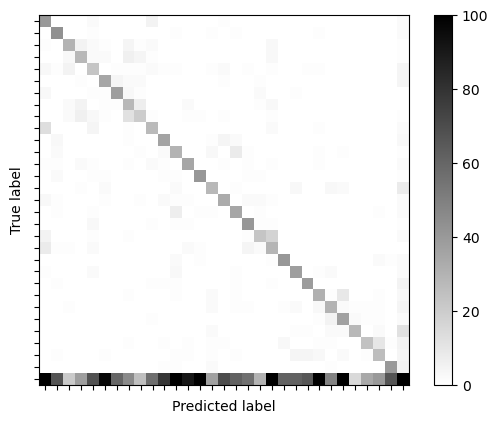

<Figure size 500x500 with 0 Axes>

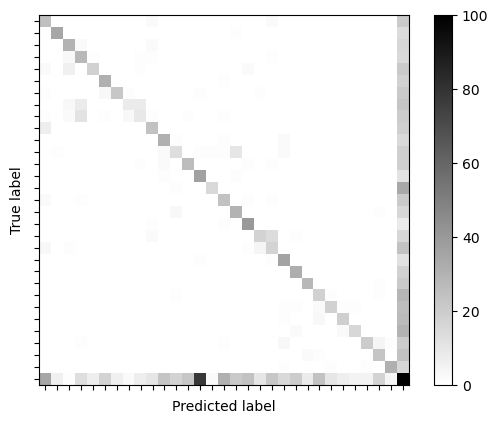

<Figure size 500x500 with 0 Axes>

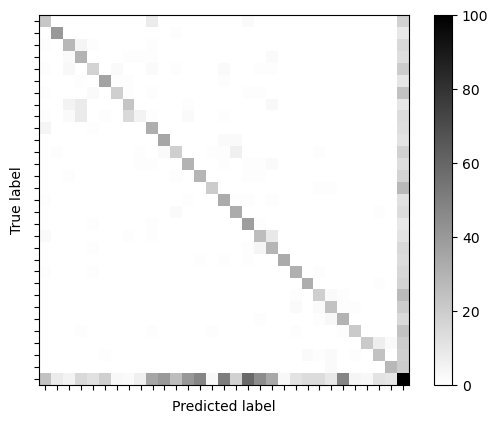

In [20]:
evals.plot_confusion_mat(data_info, colors=plt.cm.binary,
                         include_unknown=True,
                         set_diag_mask=False, set_cmap_range=(0,100),
                         show_numbers=False, diag_sort=False)

[0.34133333 0.03466667 0.01666667 0.01866667] [0.67733333 0.05933333 0.03066667 0.01666667]
[0.09733333 0.02533333 0.012      0.016     ] [0.18733333 0.03933333 0.026      0.02666667]
[0.048      0.06666667 0.05666667 0.052     ] [0.06533333 0.12666667 0.124      0.10933333]
[0.32466667 0.03       0.01666667 0.01733333] [0.64666667 0.058      0.02733333 0.02466667]


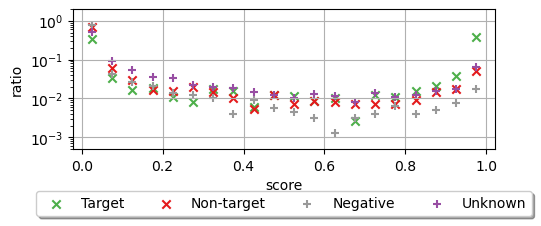

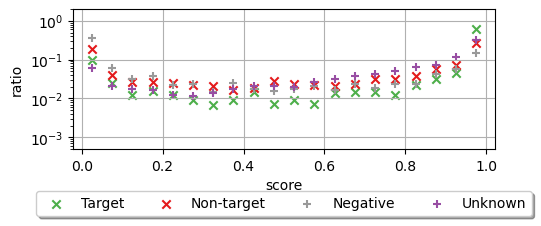

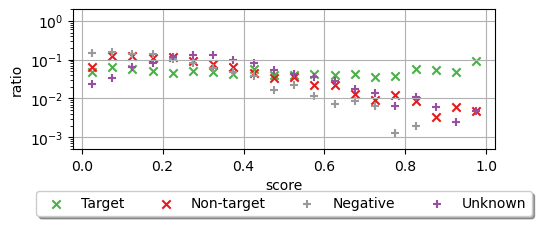

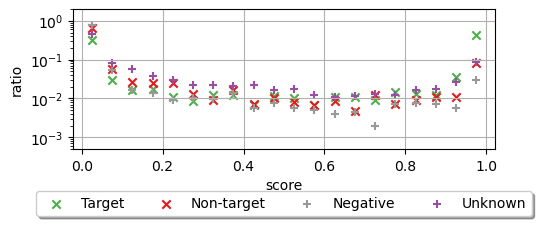

In [21]:
start, stop, step = 0, 1, 0.05
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
evals.plot_score_dist(data_info, bins, colors=colors, figsize=(5.5,2.5), ylim=(5e-4,2))

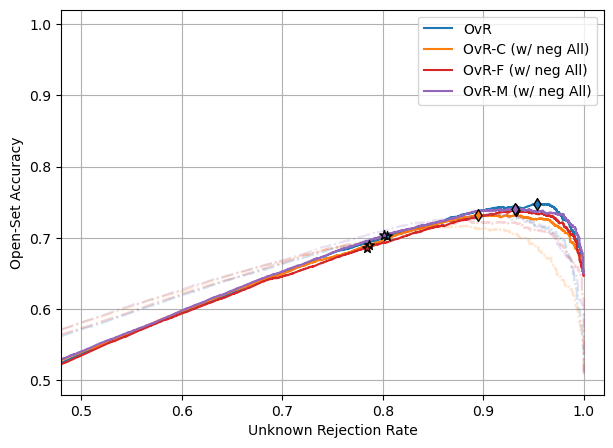

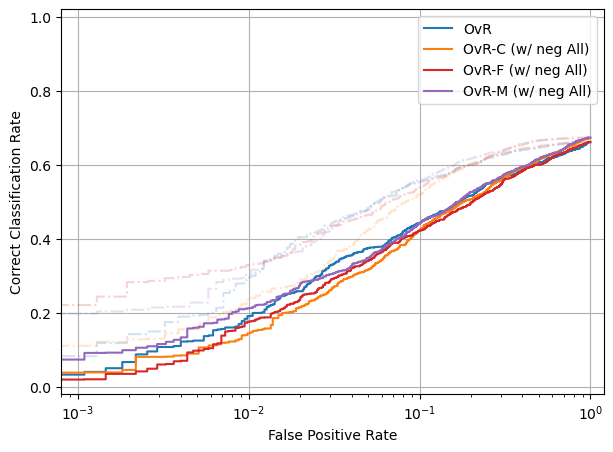

In [22]:
colors = [CMAP_t10[0],CMAP_t10[1],CMAP_t10[3], CMAP_t10[4]]
evals.plot_OSAC(data_info, colors, figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
evals.plot_OSCR(data_info, colors, figsize=(7,5), show_val=False, lim=((0.8e-3,1.2),(-.02,1.02)),)

In [62]:
data_info = ovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

results_neg_0 = evals.print_metrics(data_info, is_verbose=False)

['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_C_neg_0_g', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_F_neg_0_1', 'OvR']
['LargeScale_2', '_RQ2', 'ResNet_50_M_neg_0_04', 'OvR']
acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn


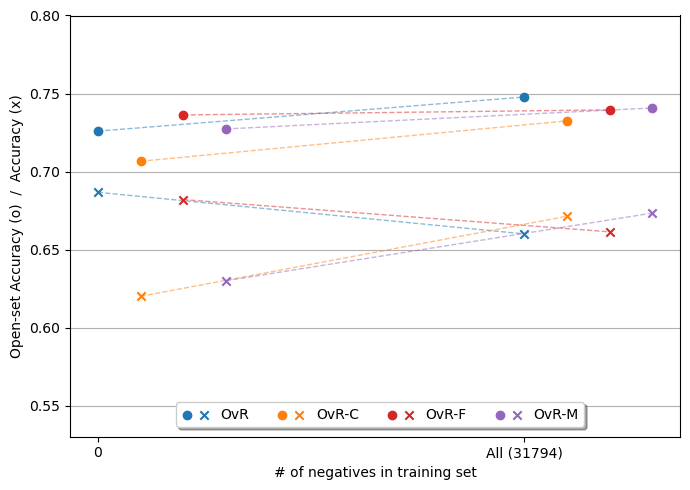

In [65]:
# results_neg_All

plot_results = [{'acc':[results_neg_0['acc'][0], results_neg_All['acc'][0]], 
                 'iosa_unkn': [results_neg_0['oosa'][0]['iosa_unkn'], results_neg_All['oosa'][0]['iosa_unkn']]}]
plot_results += [{'acc':[results_neg_0['acc'][1], results_neg_All['acc'][1]], 
                  'iosa_unkn': [results_neg_0['oosa'][1]['iosa_unkn'], results_neg_All['oosa'][1]['iosa_unkn']]}]
plot_results += [{'acc':[results_neg_0['acc'][2], results_neg_All['acc'][2]], 
                  'iosa_unkn': [results_neg_0['oosa'][2]['iosa_unkn'], results_neg_All['oosa'][2]['iosa_unkn']]}]
plot_results += [{'acc':[results_neg_0['acc'][3], results_neg_All['acc'][3]], 
                  'iosa_unkn': [results_neg_0['oosa'][3]['iosa_unkn'], results_neg_All['oosa'][3]['iosa_unkn']]}]

plot_colors = [CMAP_t10[0], CMAP_t10[1], CMAP_t10[3], CMAP_t10[4]]
plot_color_labels = ['OvR','OvR-C','OvR-F','OvR-M']

plot_items = ['iosa_unkn', 'acc']
plot_item_labels = ['Open-set Accuracy', 'Accuracy']
plot_item_ylims = [(0.53,0.80),(0.53,0.80)]
xticks = [0,'All (31794)']

evals.plot_metrics(results=plot_results, colors=plot_colors, color_labels=plot_color_labels,
                   items=plot_items, item_labels=plot_item_labels, item_ylims=plot_item_ylims, 
                   xticks=xticks)

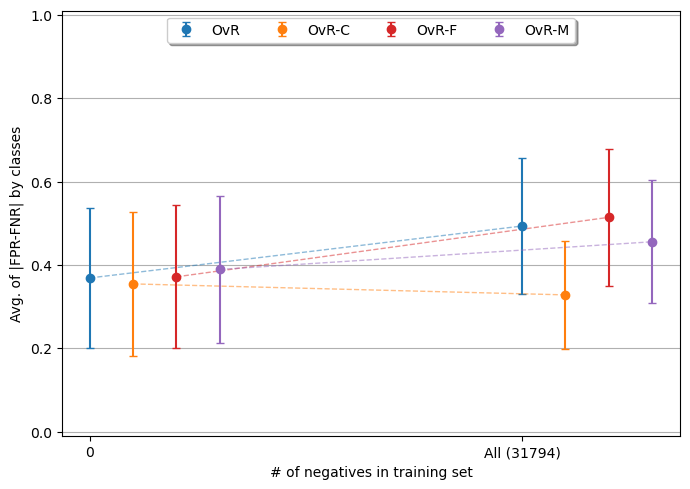

In [48]:
x = np.array([0,1])

plt.figure(figsize=(7,5))

avg = [results_neg_0['fpr_fnr'][0]['avg'], results_neg_All['fpr_fnr'][0]['avg']]
std = [results_neg_0['fpr_fnr'][0]['std'], results_neg_All['fpr_fnr'][0]['std']]
min_max = [[results_neg_0['fpr_fnr'][0]['min'], results_neg_0['fpr_fnr'][0]['max']],
           [results_neg_All['fpr_fnr'][0]['min'], results_neg_All['fpr_fnr'][0]['max']],]
plt.errorbar(x, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[0], label='OvR', ls="None")
plt.plot(x, avg, color = CMAP_t10[0], ls="--", alpha=0.5, lw=1)

avg = [results_neg_0['fpr_fnr'][1]['avg'], results_neg_All['fpr_fnr'][1]['avg']]
std = [results_neg_0['fpr_fnr'][1]['std'], results_neg_All['fpr_fnr'][1]['std']]
min_max = [[results_neg_0['fpr_fnr'][1]['min'], results_neg_0['fpr_fnr'][1]['max']],
           [results_neg_All['fpr_fnr'][1]['min'], results_neg_All['fpr_fnr'][1]['max']],]
plt.errorbar(x+0.1, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[1], label='OvR-C', ls="None")
plt.plot(x+0.1, avg, color = CMAP_t10[1], ls="--", alpha=0.5, lw=1)

avg = [results_neg_0['fpr_fnr'][2]['avg'], results_neg_All['fpr_fnr'][2]['avg']]
std = [results_neg_0['fpr_fnr'][2]['std'], results_neg_All['fpr_fnr'][2]['std']]
min_max = [[results_neg_0['fpr_fnr'][2]['min'], results_neg_0['fpr_fnr'][2]['max']],
           [results_neg_All['fpr_fnr'][2]['min'], results_neg_All['fpr_fnr'][2]['max']],]
plt.errorbar(x+0.2, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[3], label='OvR-F', ls="None")
plt.plot(x+0.2, avg, color = CMAP_t10[3], ls="--", alpha=0.5, lw=1)

avg = [results_neg_0['fpr_fnr'][3]['avg'], results_neg_All['fpr_fnr'][3]['avg']]
std = [results_neg_0['fpr_fnr'][3]['std'], results_neg_All['fpr_fnr'][3]['std']]
min_max = [[results_neg_0['fpr_fnr'][3]['min'], results_neg_0['fpr_fnr'][3]['max']],
           [results_neg_All['fpr_fnr'][3]['min'], results_neg_All['fpr_fnr'][3]['max']],]
plt.errorbar(x+0.3, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[4], label='OvR-M', ls="None")
plt.plot(x+0.3, avg, color = CMAP_t10[4], ls="--", alpha=0.5, lw=1)

plt.xticks(ticks=x, labels=[0,'All (31794)'])
plt.xlabel('# of negatives in training set')
plt.ylabel('Avg. of |FPR-FNR| by classes')
plt.ylim(-0.01,1.01)
plt.grid(axis='y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), shadow=True, ncol=4,)
plt.tight_layout()

##### OSOvR

In [66]:
data_info = osovr_data_info_3[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_2', '_RQ3', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_C_neg_All_b', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_F_neg_All_1', 'OpenSetOvR']
['LargeScale_2', '_RQ3', 'ResNet_50_M_neg_All_06', 'OpenSetOvR']


In [67]:
results_neg_All = evals.print_metrics(data_info)

acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn


0.6540	0.5245±0.1736	0.5492	0.7126	0.7111	0.7247	0.7095	0.6704
0.6447	0.3633±0.1532	0.5450	0.6983	0.6961	0.7214	0.6928	0.6880
0.7040	0.4711±0.1599	0.6057	0.7387	0.7479	0.7546	0.7472	0.6932
0.6860	0.4390±0.1597	0.5784	0.7370	0.7361	0.7351	0.7318	0.6767


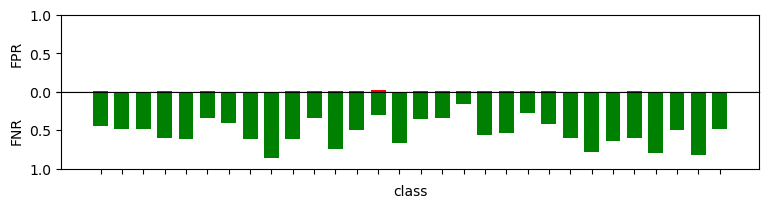

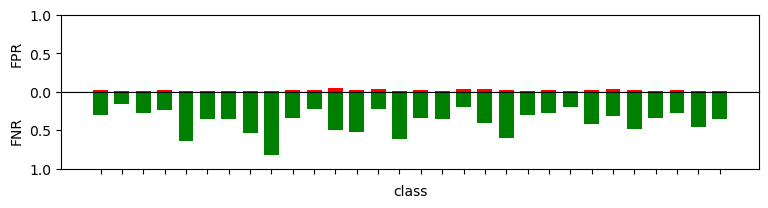

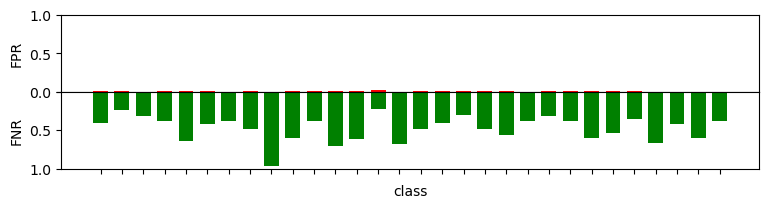

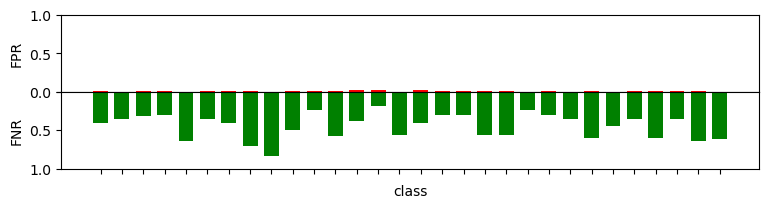

In [51]:
evals.plot_fpr_fnr_class(data_info, ylim=(0.0,1))

<Figure size 500x500 with 0 Axes>

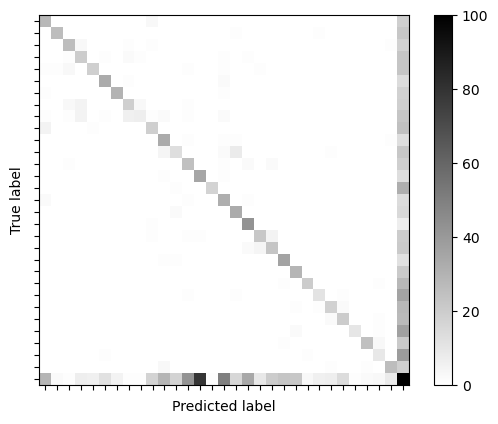

<Figure size 500x500 with 0 Axes>

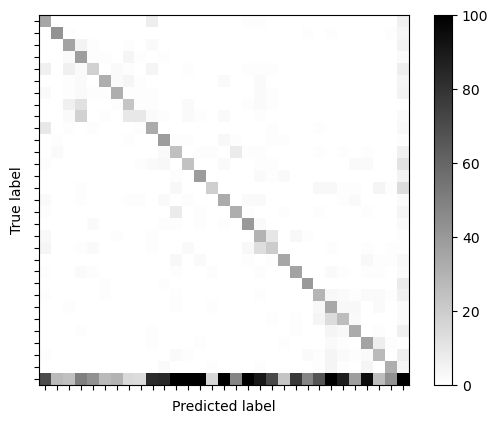

<Figure size 500x500 with 0 Axes>

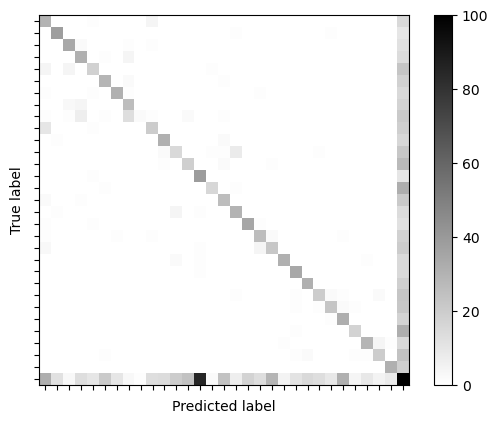

<Figure size 500x500 with 0 Axes>

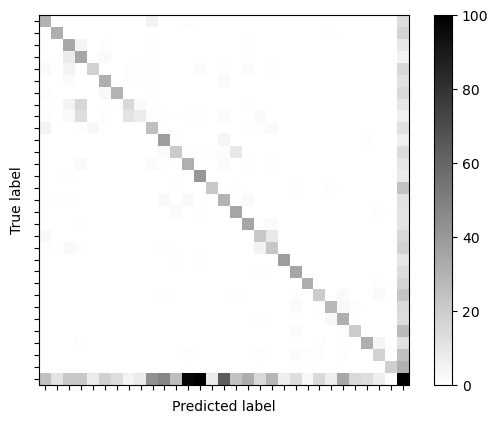

In [52]:
evals.plot_confusion_mat(data_info, colors=plt.cm.binary,
                         include_unknown=True,
                         set_diag_mask=False, set_cmap_range=(0,100),
                         show_numbers=False, diag_sort=False)

[0.36333333 0.03733333 0.032      0.01666667] [0.67666667 0.08       0.042      0.02333333]
[0.122      0.02733333 0.01666667 0.016     ] [0.15933333 0.05666667 0.04466667 0.03866667]
[0.22466667 0.054      0.044      0.03      ] [0.52       0.12066667 0.06933333 0.04733333]
[0.28066667 0.03933333 0.028      0.01866667] [0.63066667 0.05066667 0.04266667 0.02466667]


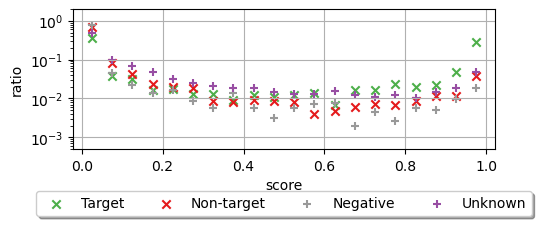

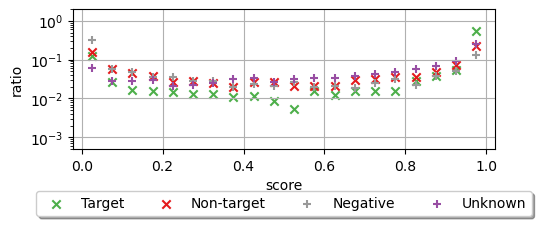

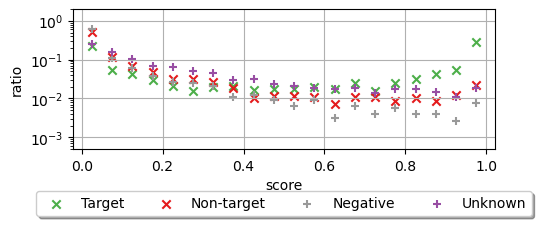

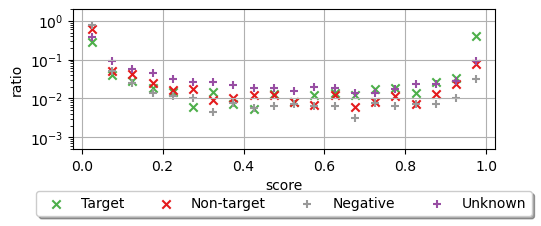

In [53]:
start, stop, step = 0, 1, 0.05
colors=(CMAP_s1[2],CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
evals.plot_score_dist(data_info, bins, colors=colors, figsize=(5.5,2.5), ylim=(5e-4,2))

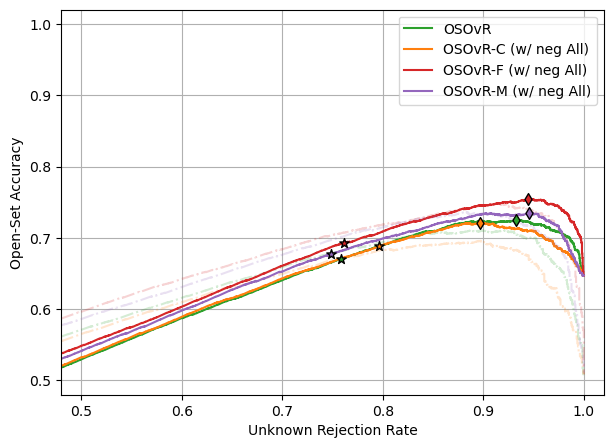

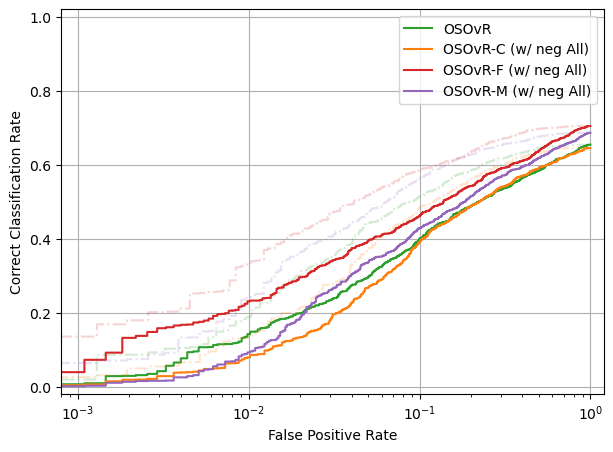

In [54]:
colors = [CMAP_t10[2],CMAP_t10[1],CMAP_t10[3], CMAP_t10[4]]
evals.plot_OSAC(data_info, colors, figsize=(7,5), lim=((0.48,1.02),(0.48,1.02)), show_val=False)
evals.plot_OSCR(data_info, colors, figsize=(7,5), show_val=False, lim=((0.8e-3,1.2),(-.02,1.02)),)

In [68]:
data_info = osovr_data_info_2[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

results_neg_0 = evals.print_metrics(data_info, is_verbose=False)

['LargeScale_2', '_RQ1', 'ResNet_50_neg_0', 'OpenSetOvR']
['LargeScale_2', '_RQ2', 'ResNet_50_C_neg_0_g', 'OpenSetOvR']
['LargeScale_2', '_RQ2', 'ResNet_50_F_neg_0_1', 'OpenSetOvR']
['LargeScale_2', '_RQ2', 'ResNet_50_M_neg_0_04', 'OpenSetOvR']
acc	|FPR-FNR|	openauc	iosa_val	iosa_neg	iosa_unkn*	oosa_neg	oosa_unkn


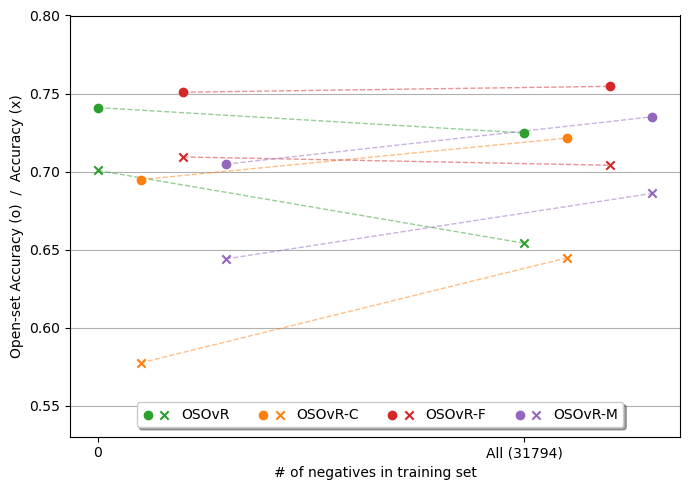

In [69]:
# results_neg_All

plot_results = [{'acc':[results_neg_0['acc'][0], results_neg_All['acc'][0]], 
                 'iosa_unkn': [results_neg_0['oosa'][0]['iosa_unkn'], results_neg_All['oosa'][0]['iosa_unkn']]}]
plot_results += [{'acc':[results_neg_0['acc'][1], results_neg_All['acc'][1]], 
                  'iosa_unkn': [results_neg_0['oosa'][1]['iosa_unkn'], results_neg_All['oosa'][1]['iosa_unkn']]}]
plot_results += [{'acc':[results_neg_0['acc'][2], results_neg_All['acc'][2]], 
                  'iosa_unkn': [results_neg_0['oosa'][2]['iosa_unkn'], results_neg_All['oosa'][2]['iosa_unkn']]}]
plot_results += [{'acc':[results_neg_0['acc'][3], results_neg_All['acc'][3]], 
                  'iosa_unkn': [results_neg_0['oosa'][3]['iosa_unkn'], results_neg_All['oosa'][3]['iosa_unkn']]}]

plot_colors = [CMAP_t10[2], CMAP_t10[1], CMAP_t10[3], CMAP_t10[4]]
plot_color_labels = ['OSOvR','OSOvR-C','OSOvR-F','OSOvR-M']

plot_items = ['iosa_unkn', 'acc']
plot_item_labels = ['Open-set Accuracy', 'Accuracy']
plot_item_ylims = [(0.53,0.80),(0.53,0.80)]
xticks = [0,'All (31794)']

evals.plot_metrics(results=plot_results, colors=plot_colors, color_labels=plot_color_labels,
                   items=plot_items, item_labels=plot_item_labels, item_ylims=plot_item_ylims, 
                   xticks=xticks)

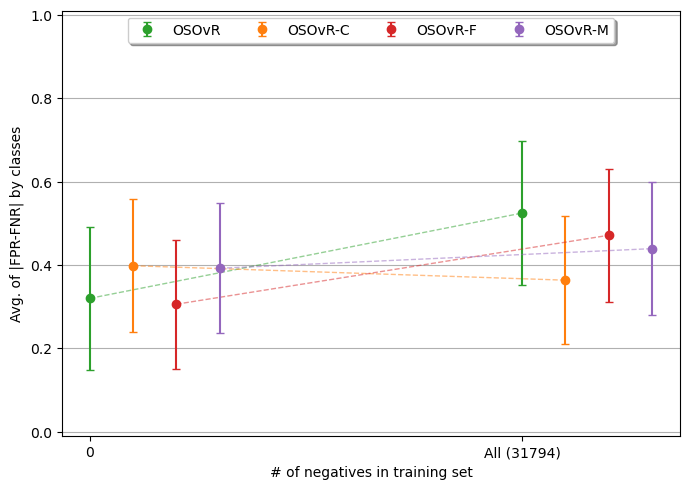

In [70]:
x = np.array([0,1])

plt.figure(figsize=(7,5))

avg = [results_neg_0['fpr_fnr'][0]['avg'], results_neg_All['fpr_fnr'][0]['avg']]
std = [results_neg_0['fpr_fnr'][0]['std'], results_neg_All['fpr_fnr'][0]['std']]
min_max = [[results_neg_0['fpr_fnr'][0]['min'], results_neg_0['fpr_fnr'][0]['max']],
           [results_neg_All['fpr_fnr'][0]['min'], results_neg_All['fpr_fnr'][0]['max']],]
plt.errorbar(x, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[2], label='OSOvR', ls="None")
plt.plot(x, avg, color = CMAP_t10[2], ls="--", alpha=0.5, lw=1)

avg = [results_neg_0['fpr_fnr'][1]['avg'], results_neg_All['fpr_fnr'][1]['avg']]
std = [results_neg_0['fpr_fnr'][1]['std'], results_neg_All['fpr_fnr'][1]['std']]
min_max = [[results_neg_0['fpr_fnr'][1]['min'], results_neg_0['fpr_fnr'][1]['max']],
           [results_neg_All['fpr_fnr'][1]['min'], results_neg_All['fpr_fnr'][1]['max']],]
plt.errorbar(x+0.1, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[1], label='OSOvR-C', ls="None")
plt.plot(x+0.1, avg, color = CMAP_t10[1], ls="--", alpha=0.5, lw=1)

avg = [results_neg_0['fpr_fnr'][2]['avg'], results_neg_All['fpr_fnr'][2]['avg']]
std = [results_neg_0['fpr_fnr'][2]['std'], results_neg_All['fpr_fnr'][2]['std']]
min_max = [[results_neg_0['fpr_fnr'][2]['min'], results_neg_0['fpr_fnr'][2]['max']],
           [results_neg_All['fpr_fnr'][2]['min'], results_neg_All['fpr_fnr'][2]['max']],]
plt.errorbar(x+0.2, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[3], label='OSOvR-F', ls="None")
plt.plot(x+0.2, avg, color = CMAP_t10[3], ls="--", alpha=0.5, lw=1)

avg = [results_neg_0['fpr_fnr'][3]['avg'], results_neg_All['fpr_fnr'][3]['avg']]
std = [results_neg_0['fpr_fnr'][3]['std'], results_neg_All['fpr_fnr'][3]['std']]
min_max = [[results_neg_0['fpr_fnr'][3]['min'], results_neg_0['fpr_fnr'][3]['max']],
           [results_neg_All['fpr_fnr'][3]['min'], results_neg_All['fpr_fnr'][3]['max']],]
plt.errorbar(x+0.3, avg, yerr=std, marker='o', capsize=3, color = CMAP_t10[4], label='OSOvR-M', ls="None")
plt.plot(x+0.3, avg, color = CMAP_t10[4], ls="--", alpha=0.5, lw=1)

plt.xticks(ticks=x, labels=[0,'All (31794)'])
plt.xlabel('# of negatives in training set')
plt.ylabel('Avg. of |FPR-FNR| by classes')
plt.ylim(-0.01,1.01)
plt.grid(axis='y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), shadow=True, ncol=4,)
plt.tight_layout()

#### Protocol 3

In [72]:
PROTOCOL = 3

data_info = ovr_data_info_2[PROTOCOL-1][-1:]
data_info += ovr_data_info_3_C[PROTOCOL-1] + ovr_data_info_3_F[PROTOCOL-1] + ovr_data_info_3_M[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx])

{'info': ['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OvR'], 'label': 'OvR (w/ neg all)'}
{'info': ['LargeScale_3', '_RQ3', 'ResNet_50_C_b', 'OvR'], 'label': 'OvR-C'}
{'info': ['LargeScale_3', '_RQ3', 'ResNet_50_F_2', 'OvR'], 'label': 'OvR-F'}
{'info': ['LargeScale_3', '_RQ3', 'ResNet_50_M_6', 'OvR'], 'label': 'OvR-M'}


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn


0.7607	0.9809	0.6746	0.7331	0.7313	0.6960	0.7335	0.7343
0.7336	0.9888	0.6352	0.6765	0.6791	0.6732	0.6793	0.6935
0.7430	0.9809	0.6527	0.7088	0.7123	0.6938	0.7137	0.7224
0.7572	0.9838	0.6663	0.7239	0.7273	0.6963	0.7281	0.7200
average	std	model
0.3688	0.180	OvR (w/ neg all)
0.2645	0.159	OvR-C
0.3922	0.172	OvR-F
0.3204	0.165	OvR-M


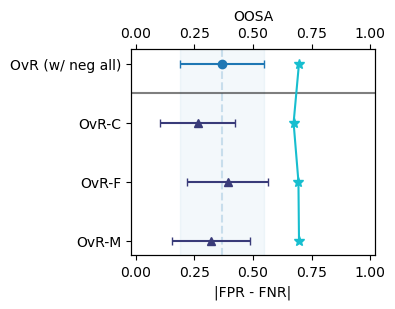

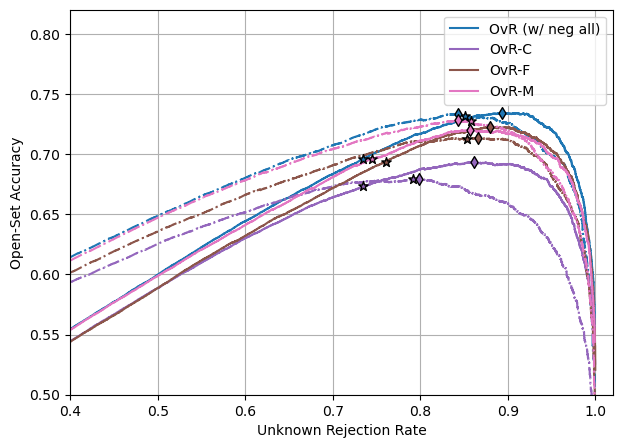

In [73]:
color = [CMAP[0]] + [CMAP_L[0]]*3
marker = ['o'] + ['^']*3

res_ovr = evals.print_metrics(data_info)
res_ovr_fpr_fnr = evals.plot_fpr_fnr(data_info, hlines=[0.5],
                                     color=color,marker=marker,
                                     figsize=(4,3.2),xlim=(-0.02,1.02), 
                                     has_oosa={'oosa':[res['oosa_unkn'] for res in res_ovr['oosa']], 'color': CMAP[9], 'lim':(-0.02,1.02)})
evals.plot_OSAC(data_info, [CMAP[0]]+CMAP[4:7],
                figsize=(7,5), lim=((0.4, 1.02),(0.5,0.82)),
                show_val=False)

In [21]:
PROTOCOL = 3

data_info = osovr_data_info_2[PROTOCOL-1][-1:]
data_info += osovr_data_info_3_C[PROTOCOL-1] + osovr_data_info_3_F[PROTOCOL-1] + osovr_data_info_3_M[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_C_g', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_F_2', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_M_4', 'OpenSetOvR']


			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.7903	0.9889	0.6986	0.7648	0.7573	0.7021	0.7586	0.7437
0.7836	0.9953	0.6520	0.7195	0.7134	0.6589	0.7144	0.6909
0.7974	0.9913	0.7132	0.7679	0.7669	0.7054	0.7679	0.7515
0.7865	0.9889	0.5762	0.6714	0.6691	0.5650	0.6706	0.6283
average	std	model
0.3315	0.168	OSOvR (w/ neg all)
0.2186	0.123	OSOvR-C
0.3251	0.173	OSOvR-F
0.3491	0.137	OSOvR-M


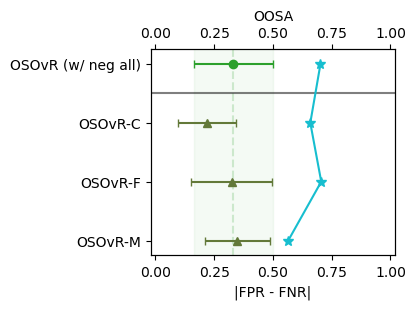

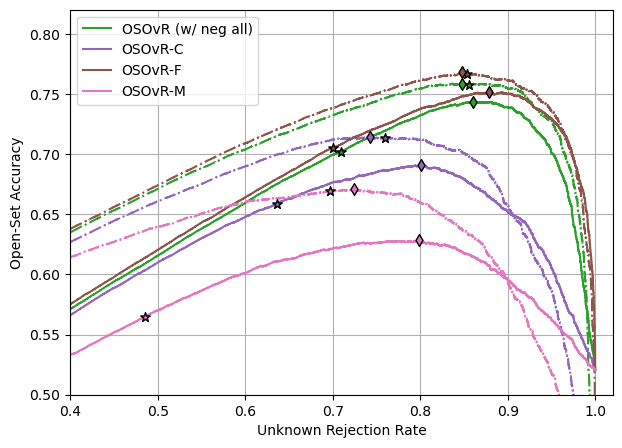

In [22]:
color = [CMAP[2]] + [CMAP_L[4]]*3
marker = ['o'] + ['^']*3

res_osovr = evals.print_metrics(data_info)
res_osovr_fpr_fnr = evals.plot_fpr_fnr(data_info, hlines=[0.5],
                                     color=color,marker=marker,
                                     figsize=(4.2,3.2),xlim=(-0.02,1.02), 
                                     has_oosa={'oosa':[res['oosa_unkn'] for res in res_osovr['oosa']], 
                                               'color': CMAP[9], 'lim':(-0.02,1.02)})
evals.plot_OSAC(data_info, [CMAP[2]]+CMAP[4:7],
                figsize=(7,5), lim=((0.4, 1.02),(0.5,0.82)),
                show_val=False)

In [62]:
PROTOCOL = 3

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1]
data_info += ovr_data_info_3_C[PROTOCOL-1] + ovr_data_info_3_F[PROTOCOL-1] + ovr_data_info_3_M[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1]
data_info += osovr_data_info_3_C[PROTOCOL-1] + osovr_data_info_3_F[PROTOCOL-1] + osovr_data_info_3_M[PROTOCOL-1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['LargeScale_3', '_RQ1', 'ResNet_50', 'SoftMax']
['LargeScale_3', '_RQ1', 'ResNet_50', 'EOS']
['LargeScale_3', '_RQ1', 'ResNet_50', 'OvR']
['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_C_b', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_F_2', 'OvR']
['LargeScale_3', '_RQ3', 'ResNet_50_M_6', 'OvR']
['LargeScale_3', '_RQ1', 'ResNet_50', 'OpenSetOvR']
['LargeScale_3', '_RQ2', 'ResNet_50_neg_All', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_C_b', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_F_2', 'OpenSetOvR']
['LargeScale_3', '_RQ3', 'ResNet_50_M_4', 'OpenSetOvR']


In [63]:
res_osovr = evals.print_metrics(data_info)

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn


0.7754	0.9940	0.6822	0.6460	0.6515	0.7227	0.6531	0.7266
0.7521	0.9783	0.6813	0.7524	0.7492	0.7053	0.7502	0.7420
0.7645	0.9876	0.6778	0.6589	0.6614	0.7260	0.6623	0.7314
0.7607	0.9809	0.6746	0.7331	0.7313	0.6960	0.7335	0.7343
0.7336	0.9888	0.6352	0.6765	0.6791	0.6732	0.6793	0.6935
0.7430	0.9809	0.6527	0.7088	0.7123	0.6938	0.7137	0.7224
0.7572	0.9838	0.6663	0.7239	0.7273	0.6963	0.7281	0.7200
0.7893	0.9915	0.6816	0.6567	0.6585	0.7178	0.6592	0.7217
0.7903	0.9889	0.6986	0.7648	0.7573	0.7021	0.7586	0.7437
0.0000	0.0000	0.0000	0.0000	0.0000	0.0000	0.0000	0.0000
0.7974	0.9913	0.7132	0.7679	0.7669	0.7054	0.7679	0.7515
0.7865	0.9889	0.5762	0.6714	0.6691	0.5650	0.6706	0.6283


### Summary

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6805	0.9789	0.6706	0.7669	0.7830	0.7671	0.7835	0.8184
0.7028	0.9765	0.6634	0.7624	0.7751	0.5597	0.7758	0.7947
0.6364	0.9834	0.5974	0.7071	0.7220	0.6670	0.7247	0.7634
0.7179	0.9824	0.6819	0.7677	0.7892	0.5679	0.7894	0.8036
0.7143	0.9873	0.6837	0.7640	0.7797	0.6826	0.7804	0.8074


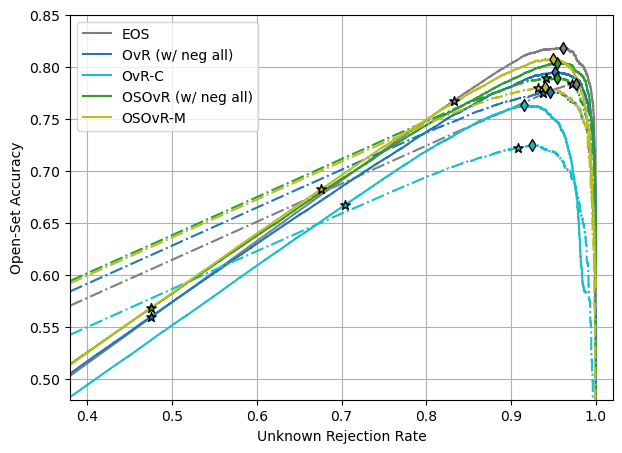

In [32]:
PROTOCOL = 1

data_info = eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1][-1:] + ovr_data_info_3_C[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1][-1:] + osovr_data_info_3_M[PROTOCOL-1]
data_info = data_info[:5]
color = [CMAP[7],CMAP[0],CMAP[9],CMAP[2],CMAP[8],]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

res = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, color, 
                figsize=(7,5), lim=((.38,1.02),(.48,.85)),
                show_val=False)

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.6567	0.9413	0.5804	0.7484	0.7393	0.6781	0.7433	0.7527
0.6600	0.9529	0.5706	0.7244	0.7269	0.7024	0.7325	0.7478
0.6733	0.9522	0.5798	0.7254	0.7315	0.7040	0.7341	0.7407
0.6540	0.9517	0.5492	0.7126	0.7095	0.6704	0.7111	0.7247
0.6533	0.9552	0.5553	0.7137	0.7118	0.7045	0.7177	0.7381


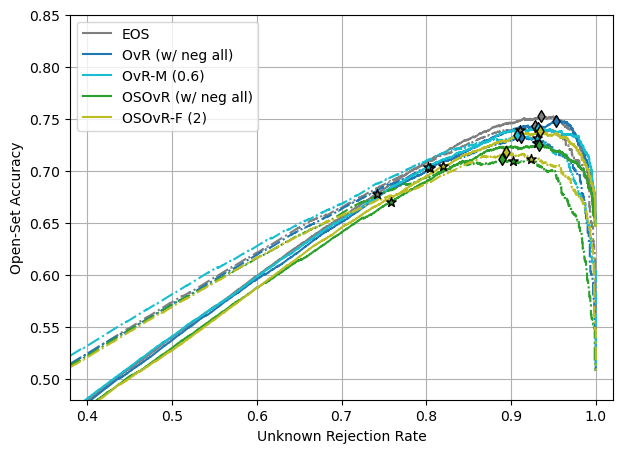

In [35]:
PROTOCOL = 2

data_info = eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1][-1:] + ovr_data_info_3_M[PROTOCOL-1][-1:]
data_info += osovr_data_info_2[PROTOCOL-1][-1:] + osovr_data_info_3_F[PROTOCOL-1][1:2]
data_info = data_info[:5]
color = [CMAP[7],CMAP[0],CMAP[9],CMAP[2],CMAP[8],]

# for idx in range(len(data_info)):
#     print(data_info[idx]['info'])

res = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, color, 
                figsize=(7,5), lim=((.38,1.02),(.48,.85)),
                show_val=False)

			oosa			iosa
acc	auroc	openauc	_val	_neg	_unkn *	_neg	_unkn
0.7521	0.9783	0.6813	0.7524	0.7492	0.7053	0.7502	0.7420
0.7607	0.9809	0.6746	0.7331	0.7313	0.6960	0.7335	0.7343
0.7572	0.9838	0.6663	0.7239	0.7273	0.6963	0.7281	0.7200
0.7903	0.9889	0.6986	0.7648	0.7573	0.7021	0.7586	0.7437
0.7974	0.9913	0.7132	0.7679	0.7669	0.7054	0.7679	0.7515


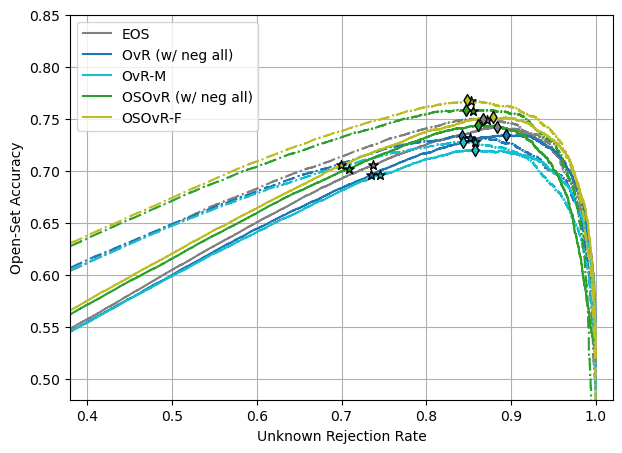

In [36]:
PROTOCOL = 3

data_info = eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1][-1:] + ovr_data_info_3_M[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1][-1:] + osovr_data_info_3_F[PROTOCOL-1]
data_info = data_info[:5]
color = [CMAP[7],CMAP[0],CMAP[9],CMAP[2],CMAP[8],]

# for idx in range(len(data_info)):
#     print(data_info[idx]['info'])

res = evals.print_metrics(data_info)
evals.plot_OSAC(data_info, color, 
                figsize=(7,5), lim=((.38,1.02),(.48,.85)),
                show_val=False)

### 4. Training progress

In [16]:
log_item_list = [('Loss/train', 'Loss', 'Training Loss'),
                 ('Loss/val', 'Loss', 'Validation Loss'),
                 ('Acc/train', 'Accuracy', 'Training Acc.'),
                 ('Acc/val', 'Accuracy', 'Validation Acc.'),
                 ('Conf/train_kn', 'Confidence', 'Training Known Confidence.'),
                 ('Conf/train_neg', 'Confidence', 'Training Negative Confidence.'),
                 ('Conf/val_kn', 'Confidence', 'Validation Known Confidence.'),
                 ('Conf/val_neg', 'Confidence', 'Validation Negative Confidence.'),]

for idx, item in enumerate(log_item_list):
    print(f"{idx} : {item[0]}")

0 : Loss/train
1 : Loss/val
2 : Acc/train
3 : Acc/val
4 : Conf/train_kn
5 : Conf/train_neg
6 : Conf/val_kn
7 : Conf/val_neg


In [38]:
ITEM_IDX = 2
log_item_list[ITEM_IDX][0]

'Acc/train'

#### Protocol 1

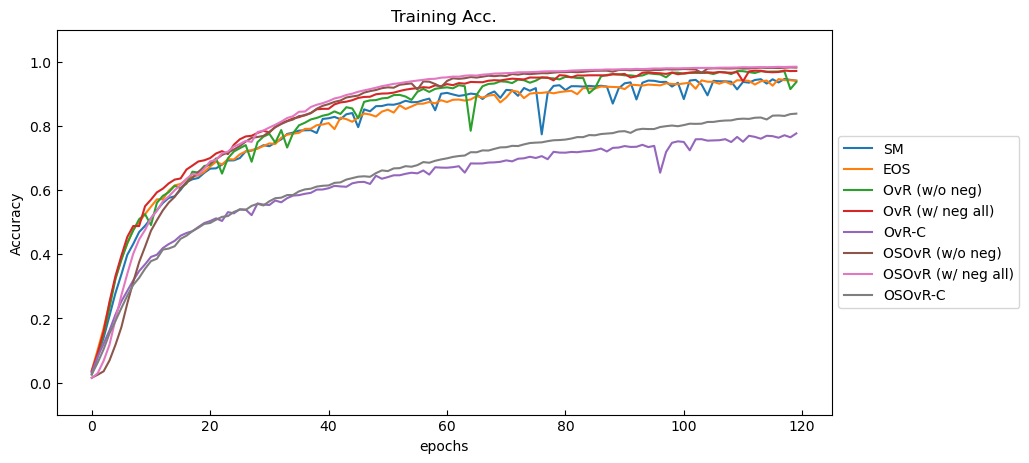

In [39]:
PROTOCOL = 1

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1] + osovr_data_info_3_C[PROTOCOL-1]

plt.figure(figsize=(10,5))
for idx, d_i in enumerate(data_info):

    logs = evals.get_training_log(d_i, log_item)

    plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')


#### Protocol 2

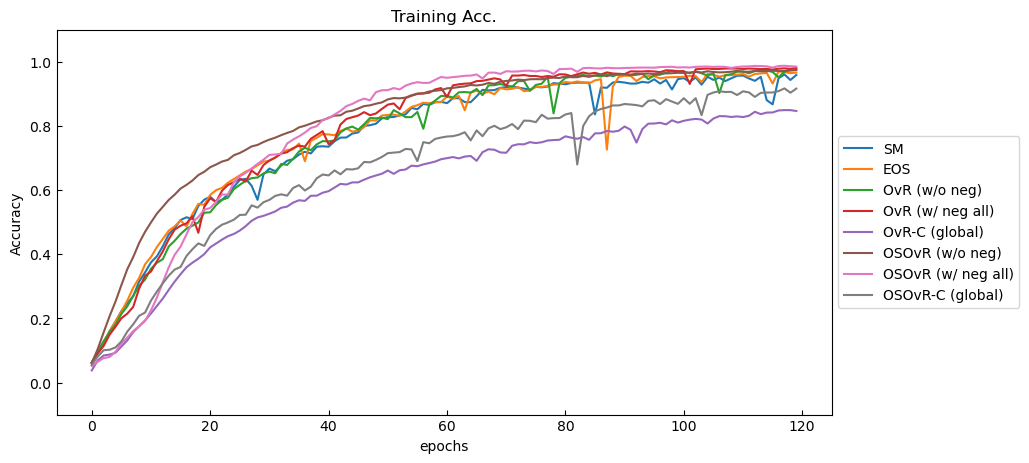

In [40]:
PROTOCOL = 2

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1][-1:]
data_info += osovr_data_info_2[PROTOCOL-1] + osovr_data_info_3_C[PROTOCOL-1][-1:]

plt.figure(figsize=(10,5))
for idx, d_i in enumerate(data_info):

    logs = evals.get_training_log(d_i, log_item)

    plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')


#### Protocol 3

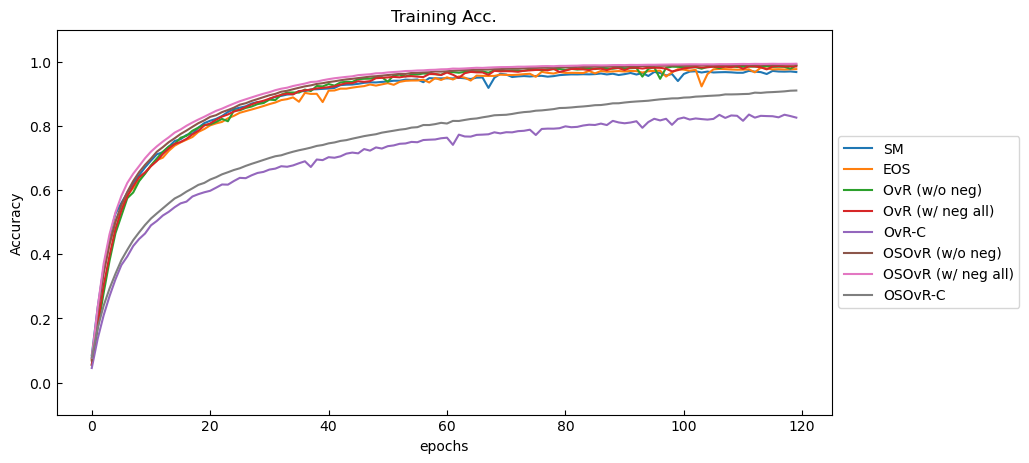

In [41]:
PROTOCOL = 3

log_item = log_item_list[ITEM_IDX][0]
y_axis_name = log_item_list[ITEM_IDX][1]
plot_title = log_item_list[ITEM_IDX][2]

data_info = sm_data_info_1[PROTOCOL-1] + eos_data_info_1[PROTOCOL-1]
data_info += ovr_data_info_2[PROTOCOL-1] + ovr_data_info_3_C[PROTOCOL-1]
data_info += osovr_data_info_2[PROTOCOL-1] + osovr_data_info_3_C[PROTOCOL-1]

plt.figure(figsize=(10,5))
for idx, d_i in enumerate(data_info):

    logs = evals.get_training_log(d_i, log_item)

    plt.plot(logs, label=d_i['label'], linestyle='-', color=CMAP[idx])
    plt.ylim((-0.1,1.1))
    plt.ylabel(y_axis_name)
    plt.xlabel('epochs')
    plt.title(plot_title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tick_params(direction='in')
